# <center> **`Banking Insights: Marketing Analysis & Prediction of Term Deposit Subscriptions`**

# **`1. Import Required Libraries`**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# **`2. Load Data`**

In [3]:
data = pd.read_csv('bank_call_data.csv', delimiter = ';')
print('Data Loaded')

Data Loaded


# **`3. Overview of the Data`**
## **`3.1. General Overview`**

In [4]:
print(f"Number of entries: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")

Number of entries: 45211
Number of features: 17


In [5]:
data.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [6]:
data.tail()

age           job   marital  education default  balance housing loan  \
45206   51    technician   married   tertiary      no      825      no   no   
45207   71       retired  divorced    primary      no     1729      no   no   
45208   72       retired   married  secondary      no     5715      no   no   
45209   57   blue-collar   married  secondary      no      668      no   no   
45210   37  entrepreneur   married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome    y  
45206   cellular   17   nov       977         3     -1         0  unknown  yes  
45207   cellular   17   nov       456         2     -1         0  unknown  yes  
45208   cellular   17   nov      1127         5    184         3  success  yes  
45209  telephone   17   nov       508         4     -1         0  unknown   no  
45210   cellular   17   nov       361         2    188        11    other   no

## **`3.2. Overview of Features - Name & Datatype`**
- `Data Conformity` check

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### **`3.1. & 3.2. Observations`**
 - The dataset is about **45211 bank customers** with total **17 columns/features** per customer including **'y'** as the **target variable**.
 - Datatypes of features are appropriate - There are **7 numeric fetaures** and **10 categorical features**.
 - Features names ensure **conformity** and no changes are required except for target feature **y**, which to be renamed as **target**.
 - Features with **object** datatype to be converted to **category** datatype.

## **`3.3. Check for Duplicate Entries`**
- `Data Uniqueness` check 

In [8]:
if data.duplicated().sum() > 0:
    print(f"There are {data.duplicated().sum()} duplicate entries in the data")
else:
    print('There are no duplicate records in the data')

There are no duplicate records in the data


## **`3.4. Check for Missing Values`**
- `Data Completeness` check

In [9]:
def check_missing_values(data):
    flag = 0
    
    missing_values = []
    col_names = []
    mv_percentage = []
    print('Missing Values:\n')
    
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            flag = 1
            missing_values.append(data[col].isnull().sum())
            mv_percentage.append(round(data[col].isnull().sum()*100/data.shape[0],2))
            col_names.append(col)
    else:
        if flag == 0:
            print('There are no missing values in the data.')
            
    mv_df = pd.DataFrame(data = {'values': missing_values, 
                                 'percentage': mv_percentage},
                         index = col_names)
    mv_df = mv_df.rename_axis(index = 'feature')
    mv_df = mv_df.sort_values(by = 'values', ascending = False)
    display(mv_df)

In [10]:
check_missing_values(data)

Missing Values:

There are no missing values in the data.


Empty DataFrame
Columns: [values, percentage]
Index: []

## **`3.5. Check for Data Correctness`**
- `Data Accuracy`, `Data Consistency`, `Data Validation` & `Data Relevancy` check

In [11]:
def check_data_accuracy(data):
    unique_count = []
    dtype = []
    
    for col in data.columns:
        unique_count.append(data[col].nunique())
        dtype.append(data[col].dtype)
    
    df_unique_count = pd.DataFrame(data = {'Unique Count': unique_count,
                                     'Data Type': dtype}, 
                                     index = data.columns)
    df_unique_count.sort_values(by = 'Unique Count', inplace = True)
    return df_unique_count

In [12]:
df_unique_count = check_data_accuracy(data)
df_unique_count

Unique Count Data Type
y                     2    object
loan                  2    object
housing               2    object
default               2    object
contact               3    object
marital               3    object
poutcome              4    object
education             4    object
job                  12    object
month                12    object
day                  31     int64
previous             41     int64
campaign             48     int64
age                  77     int64
pdays               559     int64
duration           1573     int64
balance            7168     int64

In [13]:
print('Feature-wise unique categories:\n')
for col in df_unique_count.index:
   print(f"{col}:\n{data[col].unique()}\n")

Feature-wise unique categories:

y:
['no' 'yes']

loan:
['no' 'yes']

housing:
['yes' 'no']

default:
['no' 'yes']

contact:
['unknown' 'cellular' 'telephone']

marital:
['married' 'single' 'divorced']

poutcome:
['unknown' 'failure' 'other' 'success']

education:
['tertiary' 'secondary' 'unknown' 'primary']

job:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

day:
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

previous:
[  0   3   1   4   2  11  16   6   5  10  12   7  18   9  21   8  14  15
  26  37  13  25  20  27  17  23  38  29  24  51 275  22  19  30  58  28
  32  40  55  35  41]

campaign:
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]

age:
[58 44 

#### **`3.3, 3.4 & 3.5. Observations`**
- Data is **complete** with **no duplication** of observations.
- Data seem **accurate** with real-world representation, **consistent** across features.
- Also, initial inspection suggests that data follows **valid formats** and features are **relevant** for our analysis.

# **`4. Basic Data Cleaning`**
- We will clean data as discussed in `Section 3`.

In [14]:
def basic_clean_data(data):
    data_new = data.rename(columns={'y': 'target'})
    return (
        data_new
        .assign(**{
            col: data_new[col].astype('category') 
            for col in data_new.select_dtypes('object')
        })
    )

In [15]:
df = basic_clean_data(data)
print(f"Basic Cleaning Done!")

Basic Cleaning Done!


#### **`Summary of Data (after basic cleaning)`**

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  target     45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [18]:
print(f"Number of entries in the cleaned data: {df.shape[0]}")
print(f"Number of features in the cleaned data: {df.shape[1]}")

Number of entries in the cleaned data: 45211
Number of features in the cleaned data: 17


In [19]:
df.head(2)

age         job  marital  education default  balance housing loan  contact  \
0   58  management  married   tertiary      no     2143     yes   no  unknown   
1   44  technician   single  secondary      no       29     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome target  
0    5   may       261         1     -1         0  unknown     no  
1    5   may       151         1     -1         0  unknown     no

In [20]:
df.tail(2)

age           job  marital  education default  balance housing loan  \
45209   57   blue-collar  married  secondary      no      668      no   no   
45210   37  entrepreneur  married  secondary      no     2971      no   no   

         contact  day month  duration  campaign  pdays  previous poutcome  \
45209  telephone   17   nov       508         4     -1         0  unknown   
45210   cellular   17   nov       361         2    188        11    other   

      target  
45209     no  
45210     no

In [21]:
print(f'Data retained after performing cleaning steps: {round((df.shape[0]/data.shape[0]) * 100, 2)}%')

Data retained after performing cleaning steps: 100.0%


# **`5. Exploratory Data Analysis`**

In [22]:
# Creating copy of original dataset for EDA purpose
eda_df = df.copy()
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  target     45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [23]:
eda_df.head(2)

age         job  marital  education default  balance housing loan  contact  \
0   58  management  married   tertiary      no     2143     yes   no  unknown   
1   44  technician   single  secondary      no       29     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome target  
0    5   may       261         1     -1         0  unknown     no  
1    5   may       151         1     -1         0  unknown     no

#### **`Helper Functions`**

In [24]:
def pie_plot(data, features, size_x = 10, size_y = 6, title_size = 20):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
    
        values = data[col].value_counts().values
        labels = data[col].value_counts().index
        explode = [0.05 for label in range(len(labels))]
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = plt.pie(x = values, labels = labels, autopct = '%0.2f%%', explode = explode)
        plt.title(f"Distribution of '{col}' Feature", fontdict = {'size' : title_size})
        plt.legend(labels, bbox_to_anchor=(1, 1), title = col)
    plt.tight_layout()
    plt.show()

In [25]:
def count_plot(data, features, target_col = None, size_x = 10,
               size_y = 6, title_size = 12, xticks_size = 14,
               xlabel_size = 15, ylabel_size = 15, padding = -20):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))
    for i, col in enumerate(features):
        
        plt.subplot(num_rows,num_cols,i+1)
        ax = sns.countplot(data = data, x = col, hue = target_col, edgecolor = 'black',
                           order = data[col].value_counts().index, palette = 'Spectral')
        for bars in ax.containers:
            ax.bar_label(bars, fontsize = 13, padding = padding)
            
        plt.xticks(rotation = 25, ha='right', fontsize = xticks_size)
        plt.xlabel(col, fontdict = {'size' : xlabel_size})
        plt.ylabel('Count', fontdict = {'size' : ylabel_size})
        plt.title(f"Count of '{col}' Feature", fontdict = {'size' : title_size})
        
        if target_col!= None:
            plt.legend(title = target_col)
            plt.title(f"Subscription by '{col}' Feature", fontdict = {'size' : title_size})
    plt.tight_layout()
    plt.show()

In [26]:
def conversion_rate(data, features, target_col, xtick_labels = None, size_x = 10, size_y = 6, y_lim_max = 0, rot = 0):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize=(size_x, size_y))
    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        
        df_group = data.groupby(by = col)[target_col].mean().sort_values(ascending = False)
        df_sorted = df_group.to_frame().reset_index()
        
        ax = sns.barplot(data=df_sorted, x=col, y=target_col, palette='viridis', 
                         ci=None, edgecolor = 'black', order = df_sorted[col])
        for bars in ax.containers:
            ax.bar_label(bars, labels=[f'{(label.get_height() * 100):0.2f}%' for label in bars], padding=0)
        plt.ylim(0, y_lim_max)
        plt.xticks(rotation = rot)
        plt.ylabel('Conversion Ratio')
        plt.title(f"Conversion % for '{col}' Feature", fontdict = {'size' : 12})

    plt.tight_layout()
    plt.show()

In [27]:
def bar_plot(data, features, target, hue = None, size_x = 10, size_y = 4,
             xlabel_size = 12, ylabel_size = 12, title_size = 15, bar_annot = 1):
    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x,size_y))

    for i, col in enumerate(features):
        df_group = data.groupby(by = col)[target].mean().sort_values(ascending = False)
        df_sorted = df_group.to_frame().reset_index()
        plt.subplot(num_rows, num_cols, i + 1)
        if hue == None:
            ax = sns.barplot(data = data, x = col, y = target, errorbar = None,
                             palette = 'Set1', edgecolor = 'black', order = df_sorted[col])
        else:
            ax = sns.barplot(data = data, x = col, y = target, hue = hue,
                            palette = 'Set1', edgecolor = 'black', errorbar = None, order = df_sorted[col])  
        if bar_annot == 1:
            for bars in ax.containers:
                ax.bar_label(bars, labels=[f'{(label.get_height() * 100):0.2f}%' for label in bars], padding=0)
        plt.xticks(rotation = 25, ha = 'right')
        plt.title(f'{target} vs {col}', fontsize = title_size)
        plt.xlabel(col, fontsize = xlabel_size)
        plt.ylabel(target, fontsize = ylabel_size)
        # plt.legend(bbox_to_anchor = (1,1))
    plt.tight_layout()
    plt.show()

In [28]:
def multivariate_plot(data, col, x, y, hue = None, title_template = None, order = None, col_wrap = 3,
                      height = 4, aspect = 1.2, sharex = False, sharey = False, flag = 0):
    
    fg = sns.FacetGrid(data = data, col = col, col_wrap = col_wrap, height=height, 
                       aspect = aspect, sharex = sharex, sharey = sharey)
    if hue == None:
        fg.map(sns.barplot, x, y, order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
    else:
        fg.map(sns.barplot, x, y, hue = df[hue], order = order, 
               errorbar = None, palette = 'Set1', edgecolor = 'black')
        plt.legend(title = hue, bbox_to_anchor = (1,1))

    # fg.set_axis_labels(col1, col2)
    fg.set_xlabels(x)
    fg.set_ylabels('Churn Ratio')
    fg.set_titles(template = title_template)
    
    for ax in fg.axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
        if flag == 0:
            for bars in ax.containers:
                ax.bar_label(bars, labels = [f'{label.get_height()*100:0.2f}%' for label in bars])
    
    plt.tight_layout()
    plt.show()

In [29]:
def hist_plot(data, features, hue = None, kde = True, size_x = 10, size_y = 6,
              xlabel_size = 12, ylabel_size = 12, title_size = 15):

    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x, size_y))
    
    for i, col in enumerate(features):
        plt.subplot(num_rows, num_cols, i+1)
        if hue == None:
            sns.histplot(data = data, x = col, kde = kde)
            sns.rugplot(data = data, x = col, color = 'black')
            plt.ylabel('Count', fontsize = ylabel_size)
        else:
            sns.kdeplot(data = data[data.loc[:, hue] == 0], x = col, fill = True, label = 'Not Subscribed')
            sns.kdeplot(data = data[data.loc[:, hue] == 1], x = col, fill = True, label = 'Subscribed')
            plt.legend()
            
        plt.xticks(rotation = 25, ha = 'right')
        plt.xlabel(col, fontsize = xlabel_size)
        plt.title(f'Distribution - {col}', fontsize = title_size)

    plt.tight_layout()
    plt.show()

In [30]:
def box_plot(data, features, hue = None, size_x = 10, size_y = 6,
             xlabel_size = 12, title_size = 15, color = None, fill = False):

    num_plots = len(features)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    plt.figure(figsize = (size_x, size_y))
    
    for i, col in enumerate(features):    
        plt.subplot(num_rows, num_cols, i+1)
        sns.boxplot(data = data, x = col, hue = hue, color = color, fill = fill)
        plt.xticks(rotation = 25, ha = 'right')
        plt.xlabel(col, fontsize = xlabel_size)
        plt.title(f'Boxplot - {col}', fontsize = title_size)
        if hue != None:
            plt.legend(bbox_to_anchor = (1,1))
        
    plt.tight_layout()
    plt.show()

### **`5.1. Basic Sanity Checks`**

In [31]:
print('Feature wise distribution of respective categories:\n')
for col in eda_df.columns:
    print(f"{eda_df[col].value_counts(normalize=True)*100}\n")
    print('-' * 50)

Feature wise distribution of respective categories:

age
32    4.611710
31    4.414855
33    4.361770
34    4.268873
35    4.189246
        ...   
93    0.004424
90    0.004424
95    0.004424
88    0.004424
94    0.002212
Name: proportion, Length: 77, dtype: float64

--------------------------------------------------
job
blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: proportion, dtype: float64

--------------------------------------------------
marital
married     60.193316
single      28.289576
divorced    11.517109
Name: proportion, dtype: float64

--------------------------------------------------
education
secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: p

In [32]:
eda_df.select_dtypes('number').describe().T

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0  
pdays        871.0  
previous     275.0

#### **`5.1. Observations`**

**`Job`**

- **job** is a **categorical** feature indicating the job types of customers.
- There are **12 unique** job profiles of which **blue-collar** and **management** seems to be *most common*, whereas **student** and **unknown** are the *least common* job profiles.
- There are certain categories of **job** feature which are **very rare**. They might make it difficult for the model to generalize, as such categories are underrepresented. Therefore to handle this bias, a new grouped feature to be formed that clubs together categories and thereby ensuring fair distribution.
- The labels with count contribution less than **5%** can be clubbed together to have a fair distribution.
- **entrepreneur**, **self-employed** and **housemaid** to be grouped under **self-driven**.
- **unemployed**, **student** to be grouped as **unemployed**.
  
**`Month`**
- **month** is a **categorical** feature that shows the last contact month of the year.
- **may** is the *most frequent* and **dec** is the *least frequent* category.
- To make the distribution fair enough, a new grouped feature to be introduced that transforms the **month** feature into **quarter-wise (Financial Quarters)** categories:
    - Financial **Q1 - Apr, May & June**
    - Financial **Q2 - Jul, Aug & Sep**
    - Financial **Q3 - Oct, Nov & Dec**
    - Financial **Q4 - Jan, Feb & Mar**

**`Target`**
- For aggregation purposes, a new **encoded** variant of target to be introduced.

In [33]:
def group_job_categories(row):
    if row['job'] in ['self-employed', 'entrepreneur', 'housemaid']:
        return 'self-driven'
    elif row['job'] in ['student', 'unemployed']:
        return 'unemployed'
    else:
        return row['job']

In [34]:
eda_df = (
    eda_df
    .assign(
        quarter = lambda df_: df_['month'].map({'apr':1,'may':1,'jun':1,
                                                'jul':2,'aug':2,'sep':2,
                                                'oct':3,'nov':3,'dec':3,
                                                'jan':4,'feb':4,'mar':4}
                                              ).astype('category'),
        job_group = lambda df_: df_.apply(group_job_categories, axis = 1).astype('category'),
        target_encoded = lambda df_: df_['target'].map({'no': 0, 'yes': 1}).astype('int')
    )
)

In [35]:
eda_df.head(2)

age         job  marital  education default  balance housing loan  contact  \
0   58  management  married   tertiary      no     2143     yes   no  unknown   
1   44  technician   single  secondary      no       29     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome target quarter  \
0    5   may       261         1     -1         0  unknown     no       1   
1    5   may       151         1     -1         0  unknown     no       1   

    job_group  target_encoded  
0  management               0  
1  technician               0

In [36]:
categorical_cols = eda_df.select_dtypes('category').columns.to_list()
numerical_cols = eda_df.select_dtypes('number').columns.to_list()

print(f'Categorical Columns: Count {len(categorical_cols)}\n{categorical_cols}\n')
print(f'Numerical Columns: Count {len(numerical_cols)}\n{numerical_cols}')

Categorical Columns: Count 12
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'target', 'quarter', 'job_group']

Numerical Columns: Count 8
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'target_encoded']


## **`5.2. EDA - Target Feature`**
### **`5.2.1. Basic Descriptive Stats`**

In [37]:
eda_df['target'].describe().to_frame().T

count unique top   freq
target  45211      2  no  39922

### **`5.2.2. Univariate Analysis`**

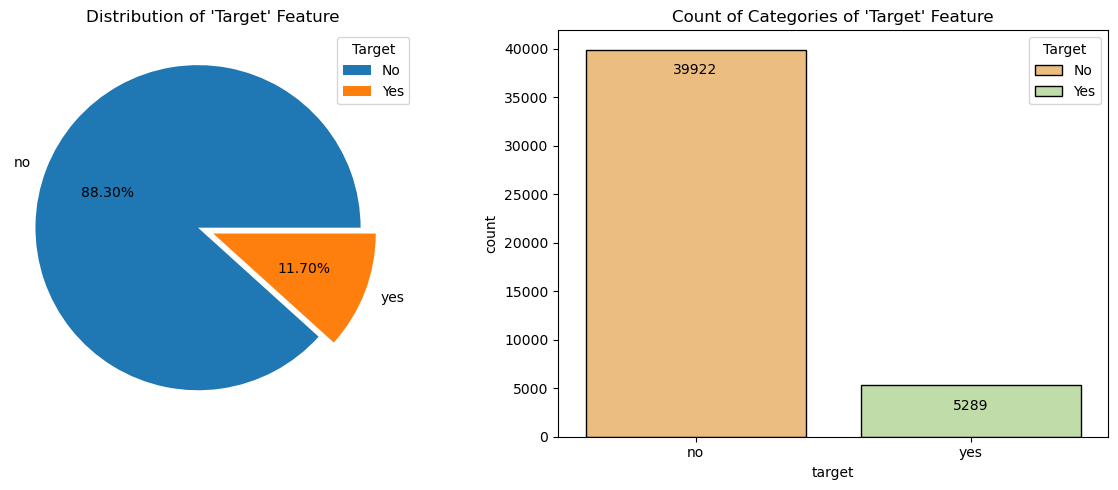

In [38]:
values = eda_df['target'].value_counts().values
labels = eda_df['target'].value_counts().index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(x=values, labels=labels, autopct='%0.2f%%', explode=[0.1, 0])
plt.legend(title = 'Target', labels=['No', 'Yes'])
plt.title("Distribution of 'Target' Feature")

plt.subplot(1, 2, 2)
ax = sns.countplot(data=df, x='target', edgecolor = 'black', palette = 'Spectral')
for bars in ax.containers:
    ax.bar_label(bars, padding = -20)
plt.legend(title = 'Target', labels=['No', 'Yes'])
plt.title("Count of Categories of 'Target' Feature")

plt.tight_layout()
plt.show()

#### **`5.2.2. Observations`**
- With only **11.70%** customers **(5289) subscribed** to term deposits, the response to campaign is concerning for a bank.
- Major chunk of customers **88.30%** customers **(39922)** showed no interest in the campaign.
- The distribution of **target** feature is highly **imbalanced**, however the necessary steps for handling the imbalance to be taken in the later stage of modeling.

## **`5.3. EDA - Categorical Features`**

In [39]:
binary_categories = ['housing', 'default', 'loan']
multi_category1 = ['marital', 'education', 'job', 'job_group']
multi_category2 = ['month', 'quarter', 'contact', 'poutcome']

### **`5.3.1. Basic Descriptive Stats`**

In [40]:
eda_df.select_dtypes('category').describe()

job  marital  education default housing   loan   contact  \
count         45211    45211      45211   45211   45211  45211     45211   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
freq           9732    27214      23202   44396   25130  37967     29285   

        month poutcome target  quarter    job_group  
count   45211    45211  45211    45211        45211  
unique     12        4      2        4            9  
top       may  unknown     no        1  blue-collar  
freq    13766    36959  39922    22039         9732

### **`5.3.2. Univariate Analysis`**

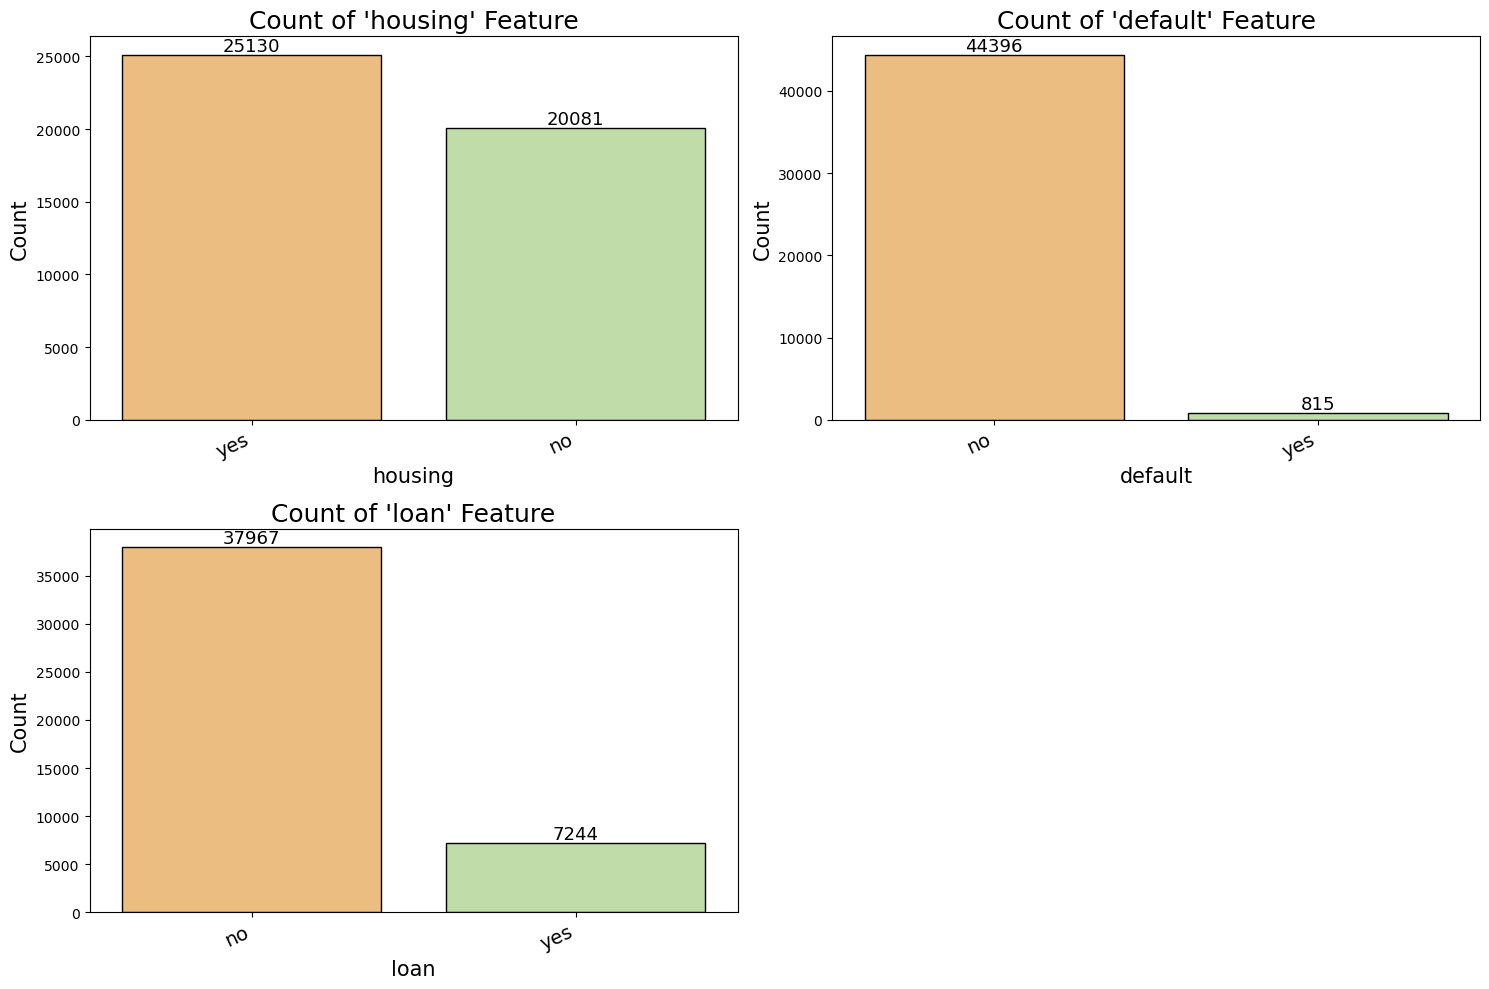

In [41]:
count_plot(data = eda_df,
           features = binary_categories,
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18,
           padding = 0)

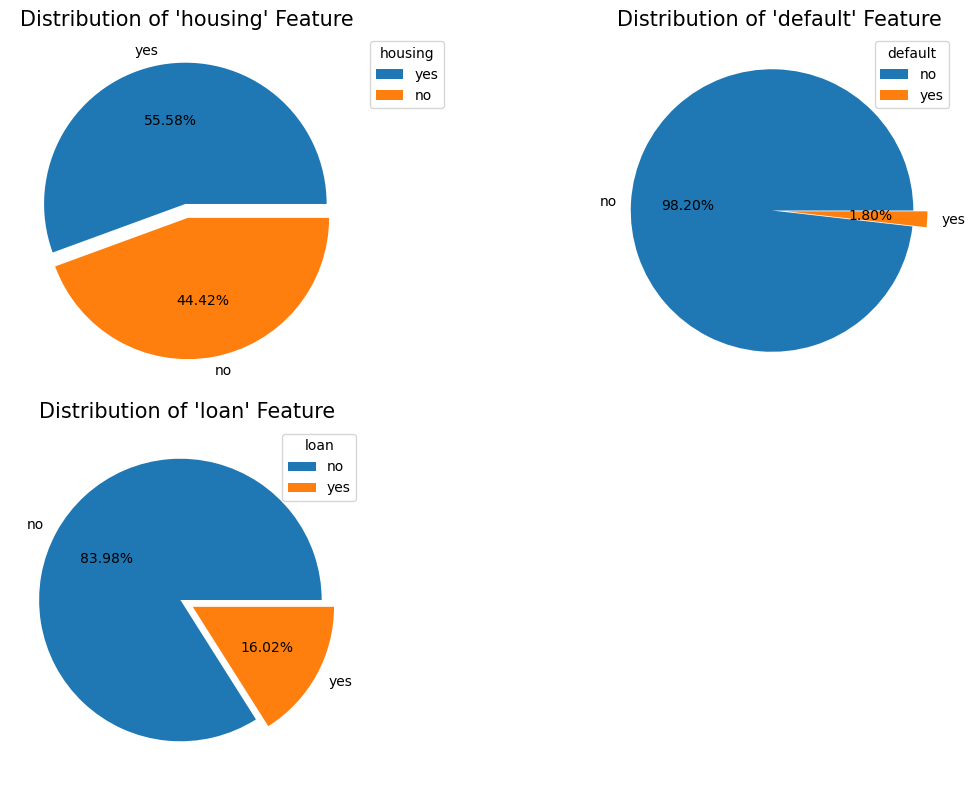

In [42]:
pie_plot(data = df,
         features = binary_categories,
         size_x = 12,
         size_y = 8,
         title_size = 15)

#### **`Observations`**
**`Housing Loan`**
- **housing** feature indicates whether a customer has availed **housing loan facility**. 
- Customers **with housing loan** are **more (25130 - 55.6%)** than customers who **did not opt (20081 - 44.4%)**.
- It is safe to assume that the distribution of categories is **fairly balanced**.

**`Personal Loan`**
- **loan** feature indicates whether a customer has availed **personal loan facility**.
- **Majority** of customers **(37967)** have **not availed** personal loan, with only a **small segment** of customers **(7244)** **having** personal loan **(84% availed vs 16% not availed)**.

**`Default Status`**
- A little less than **2%** of customers **(815)** have **defaulted**.
- Most customers **(44396)** - **98%** have **no** history of credit default.
- Customers do have **strong credit history**, which is a positive trait for a bank.

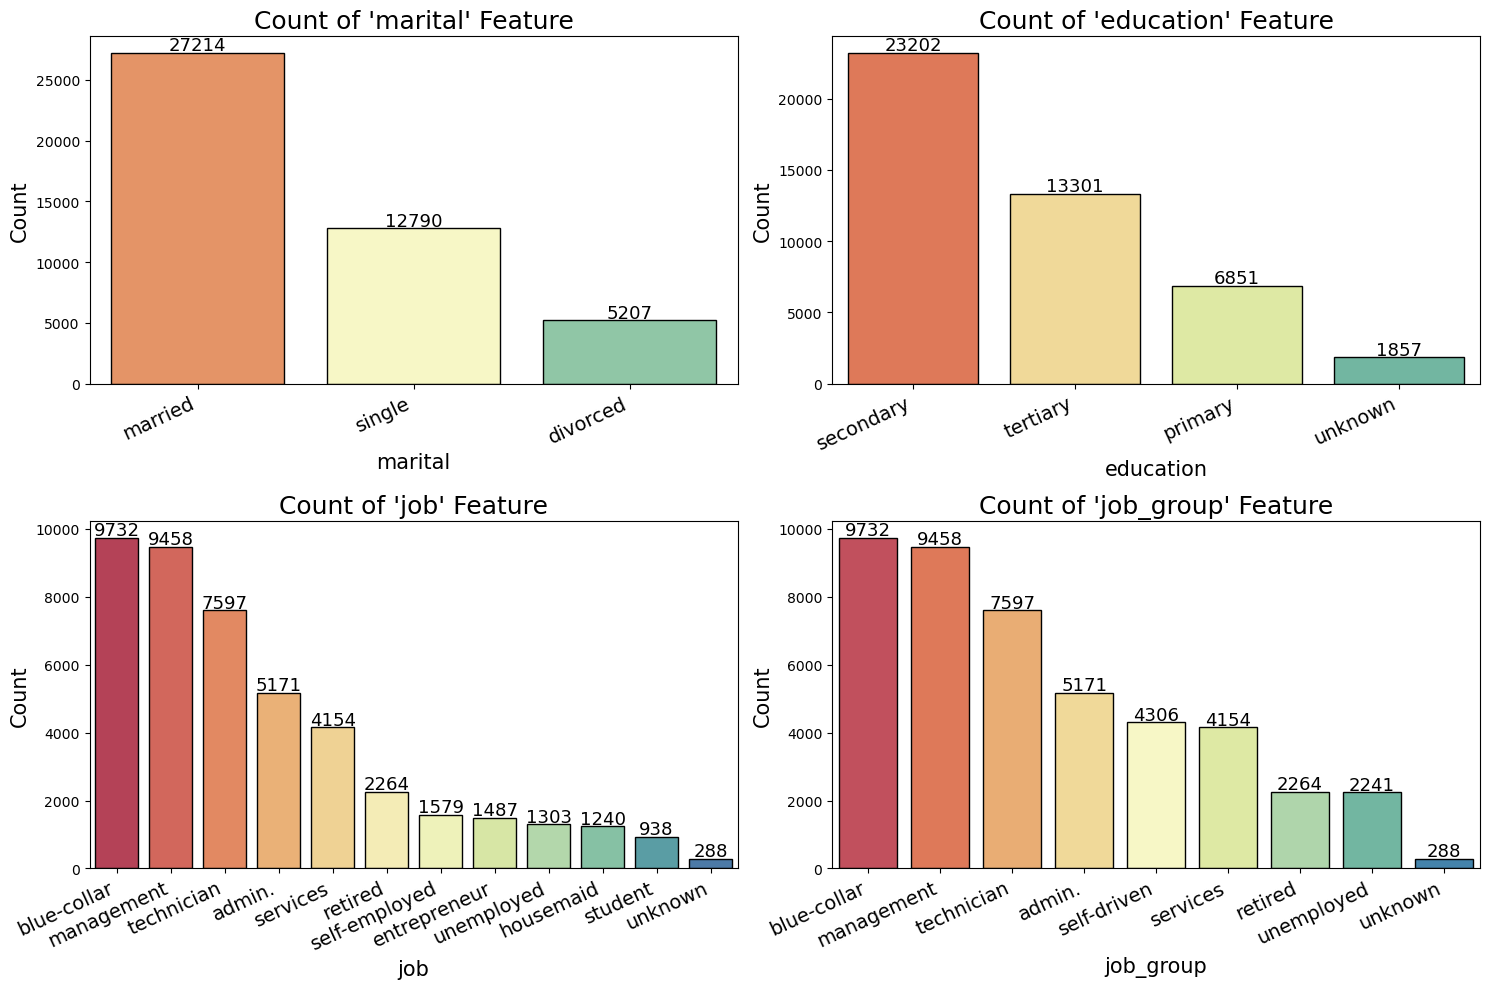

In [43]:
count_plot(data = eda_df,
           features = multi_category1,
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18,
           padding = -1)

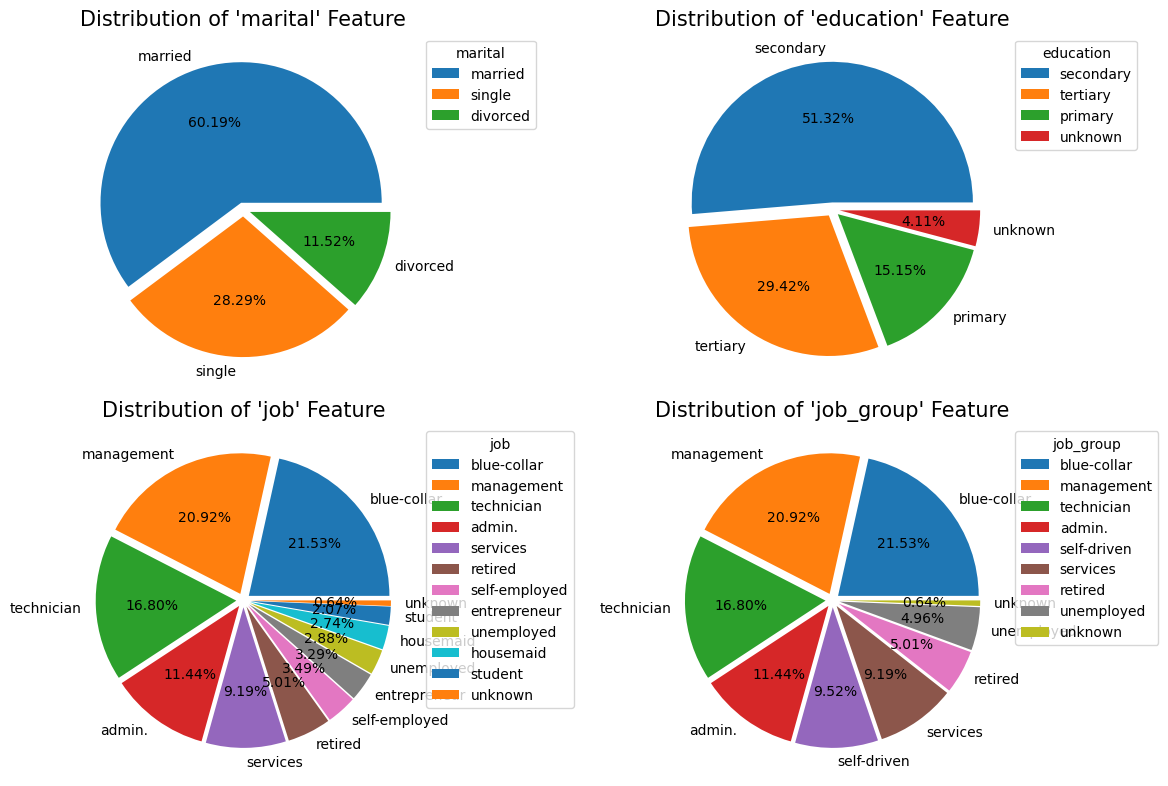

In [44]:
pie_plot(data = eda_df,
         features = multi_category1,
         size_x = 12,
         size_y = 8,
         title_size = 15)

#### **`Observations`**
**`Marital Status`**
- There are **3** unique categories of marital status - **married, single & divorced**.
- **Majority** of customers are **married (27214 - 60%)**.
- **Singles** form the second-largest group with count of **12790 (28%)**.
- **Divorced** is the **least** common category **(5207 - about 12%)**.

**`Education Level`**
- **education** is a categorical feature that indicates the level of education for customers.
- A little **more than half** of the customers have **secondary** level education **(51.32%)**, followed by **tertiary** with **29.4%** and **primary** with **15.15%**.
- This feature is **concerning** as there are about **4.1%** customers whose education is **not captured** and is labeled as **unknown**.

**`Job & Job-Group`**
- **blue-collar** is the **most common** education level with **21.53%** share followed closely by **management (20.92%)**.
- **technician, admin & services** form the mid categories in terms of count.
- The rest levels are **rare** with a share less than **5%**. Grouped job levels ensures semantic groupings.
- **unknown** category has **288** instances which are kept as is. To capture the absence, a **binary flag** can be introduced.

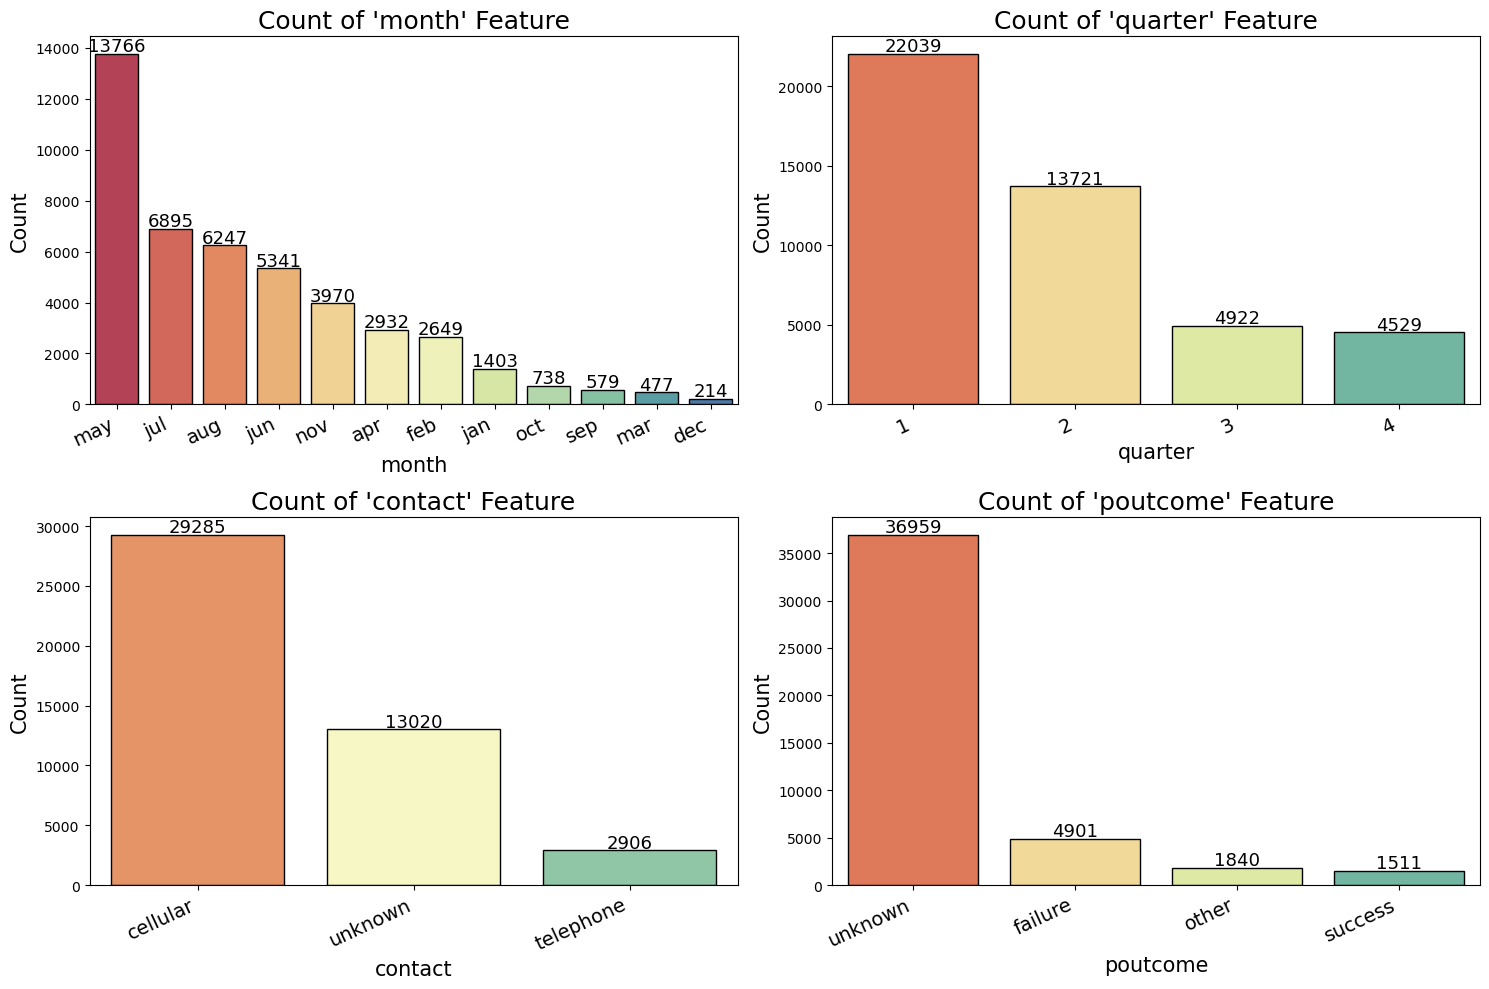

In [45]:
count_plot(data = eda_df,
           features = multi_category2,
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18,
           padding = -1)

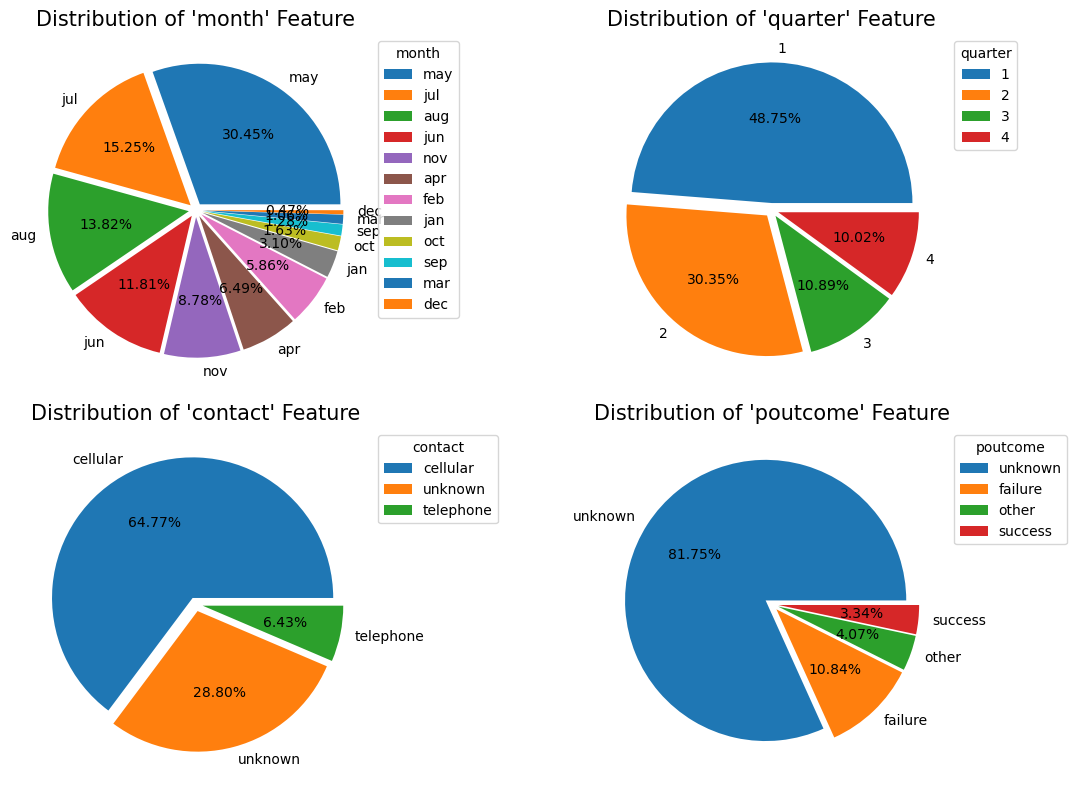

In [46]:
pie_plot(data = eda_df,
         features = multi_category2,
         size_x = 12,
         size_y = 8,
         title_size = 15)

#### **`Observations`**
**`Month` & `Quarter`**
- Month of **May** recorded the highest contacts **(13766)** made for campaign.
- Customers were also contacted rigorously in the months of **July, August & June** indicating efforts for conversion.
- **December** showed the least campaign activity with just **214** instances.
- These month-wise contacts count suggest that campaign was active with major targets during these months. Maybe because this marks the start of new financial year.
- **Quarter-wise** distribution encapsulates the high-level overview - instances of contacts made **decreased** as we move on to each next quarter.
- Financial **Q1** reported close to **49%** instances in terms of last contact made, followed by **Q2 (30%), Q3 (11%)**.
- The last financial quarter **(Q4)** is the least common with only **10%** of the total instances.

**`Contact Mode`**
- **contact** is a categorical feature that indicates the **communication type** during campaign marketing.
- **Majority** of customers **(64.7%, 29285)** are communicated via **cellular** mode, whereas customers contacted with **telephone** mode constitutes the least **(6.4%, 2906)** portion.
- It is concerning that around **29% (13020)** of the communication mode is **not captured** properly and is categorized as **unknown**. It could be personal visit, brochure marketing, digital marketing and so on. But since it is not specified, we will keep the category 'unknown' as it is in order to capture the effect in the overall analysis.

**`Previous Outcome`**
- Categorical feature **`poutcome`** captures results of the **previouly** conducted marketing **campaign**.
- Around **82%** of cases do not provide any meaningful insight about previous campaign, as the **performance outcome** is **not known**.
- **4901** customers declined previous campaign resulting into **11% failure** instances.
- Sure **success** was reported for **1511** customers that forms the **least** frequent category with **3.34%** proportion.
- Among the sure outcomes that are known, there is a category with label **other** with a notable share of **4.07% (1840)**. These customers could've possibly **showed interest** and assured for subscriptions in next campaign or so.
- **other** category can be further combined with the results of **active campaign** to see if the above case was true. 

### **`5.3.3. Bivariate Analysis`**

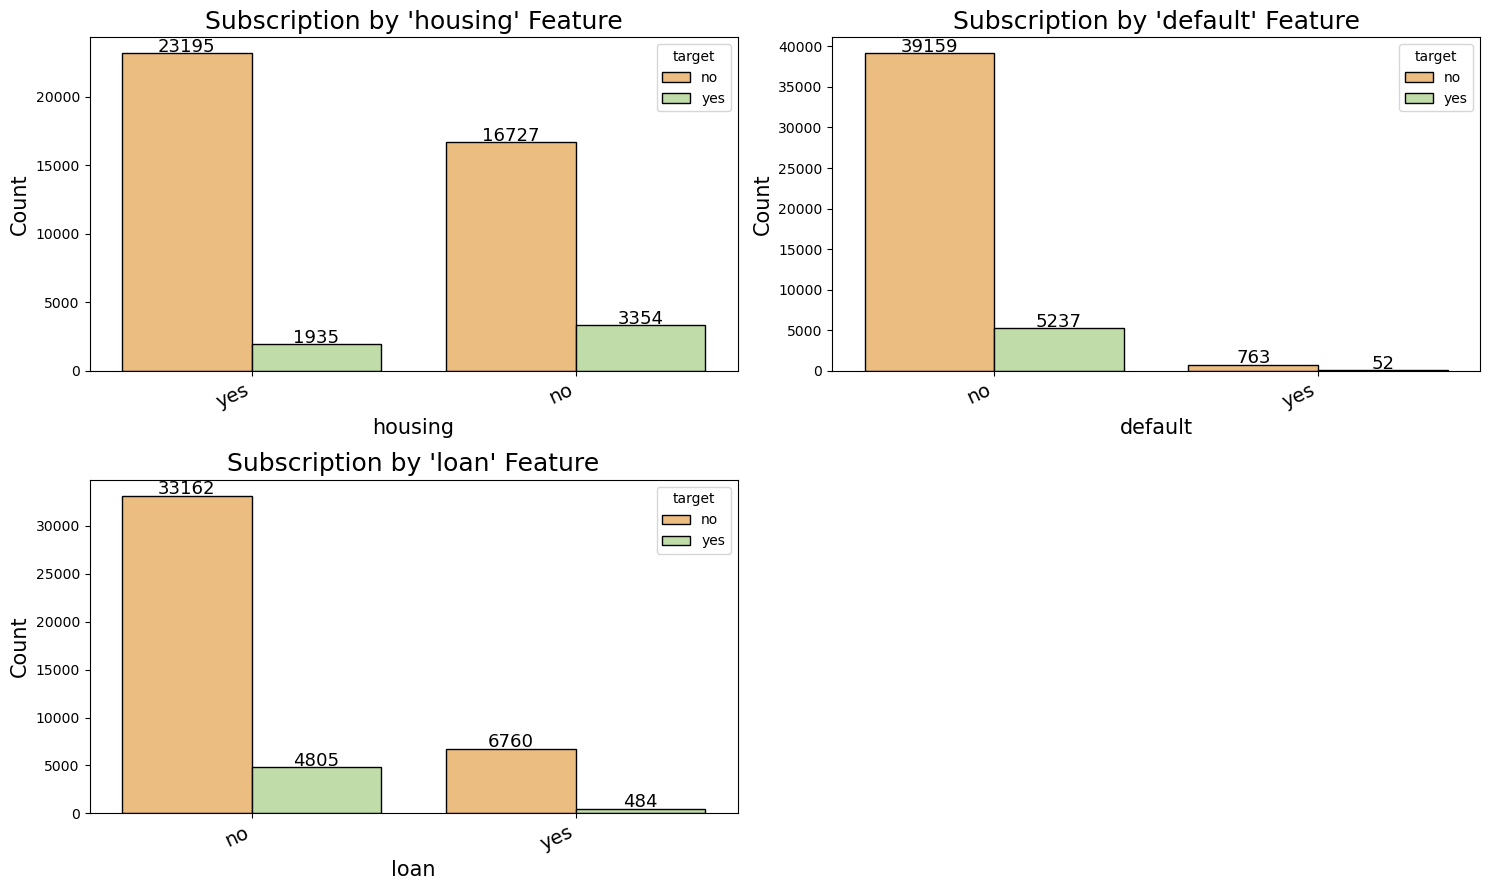

In [47]:
count_plot(data = eda_df,
           features = binary_categories,
           target_col = 'target',
           size_x = 15,
           size_y = 9,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18, padding = -2)

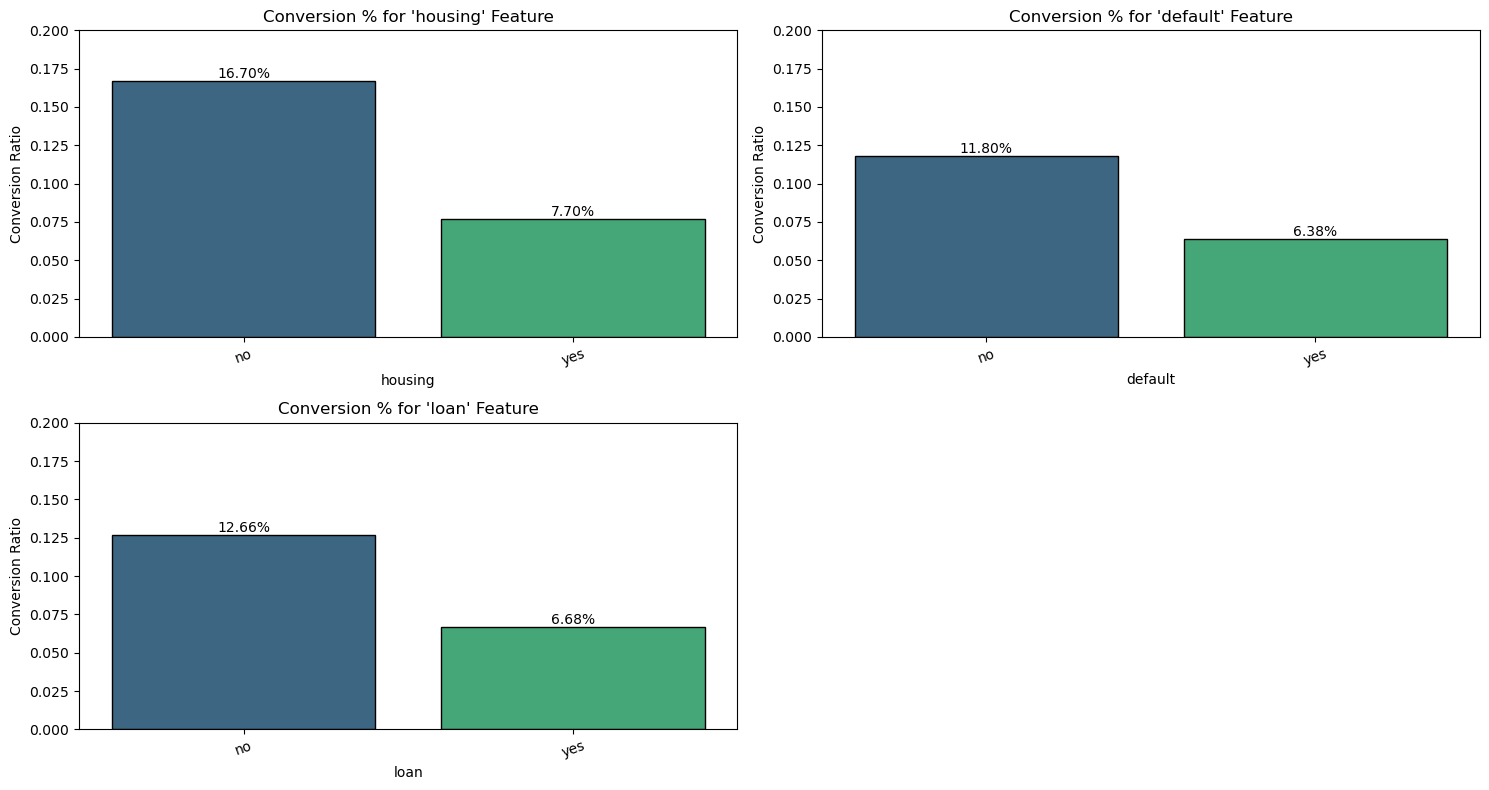

In [48]:
conversion_rate(data = eda_df,
           features = binary_categories,
           target_col = 'target_encoded',
           y_lim_max = 0.20,
           size_x = 15,
           size_y = 8,
           rot = 20)

#### **`Observations - Subscription Rate`**
**`Housing Loan`**
- Customers with housing loan lead the group with a margin count of **5049**.
- However, customers with **no housing loan** have subscribed in more numbers **(3354 out of 20081)**.
- Whereas, **1935 (out of 25130)** customers **with housing loan** have subscribed to term deposits.
- Likelihood of conversion is therefore **16.70%** among those with **no housing loan** as opposed to **7.70%** among those with **housing loans**.
- Debt activeness or need of financial stability might be the reason for non-interest in term deposits.

**`Default Status`**
- With major section having **no** default, **5237** customers have subscribed making conversions of upto **11.80%**.
- As for the **default** status - the count of subscriptions is low with only **52** customers responding positively to campaign.
- This clearly indicates **credit history** might have impacted their decisions.
- However, **targeted approach** might **improve** conversion rates.

**`Personal Loan`**
- Again, customers with **no financial obligation** have slightly higher subscriptions **(4805 out of 37967)** with conversion rate of **12.66%**.
- Customers who do have personal loan have subscribed at **6.68% (484 out of 6760)**.

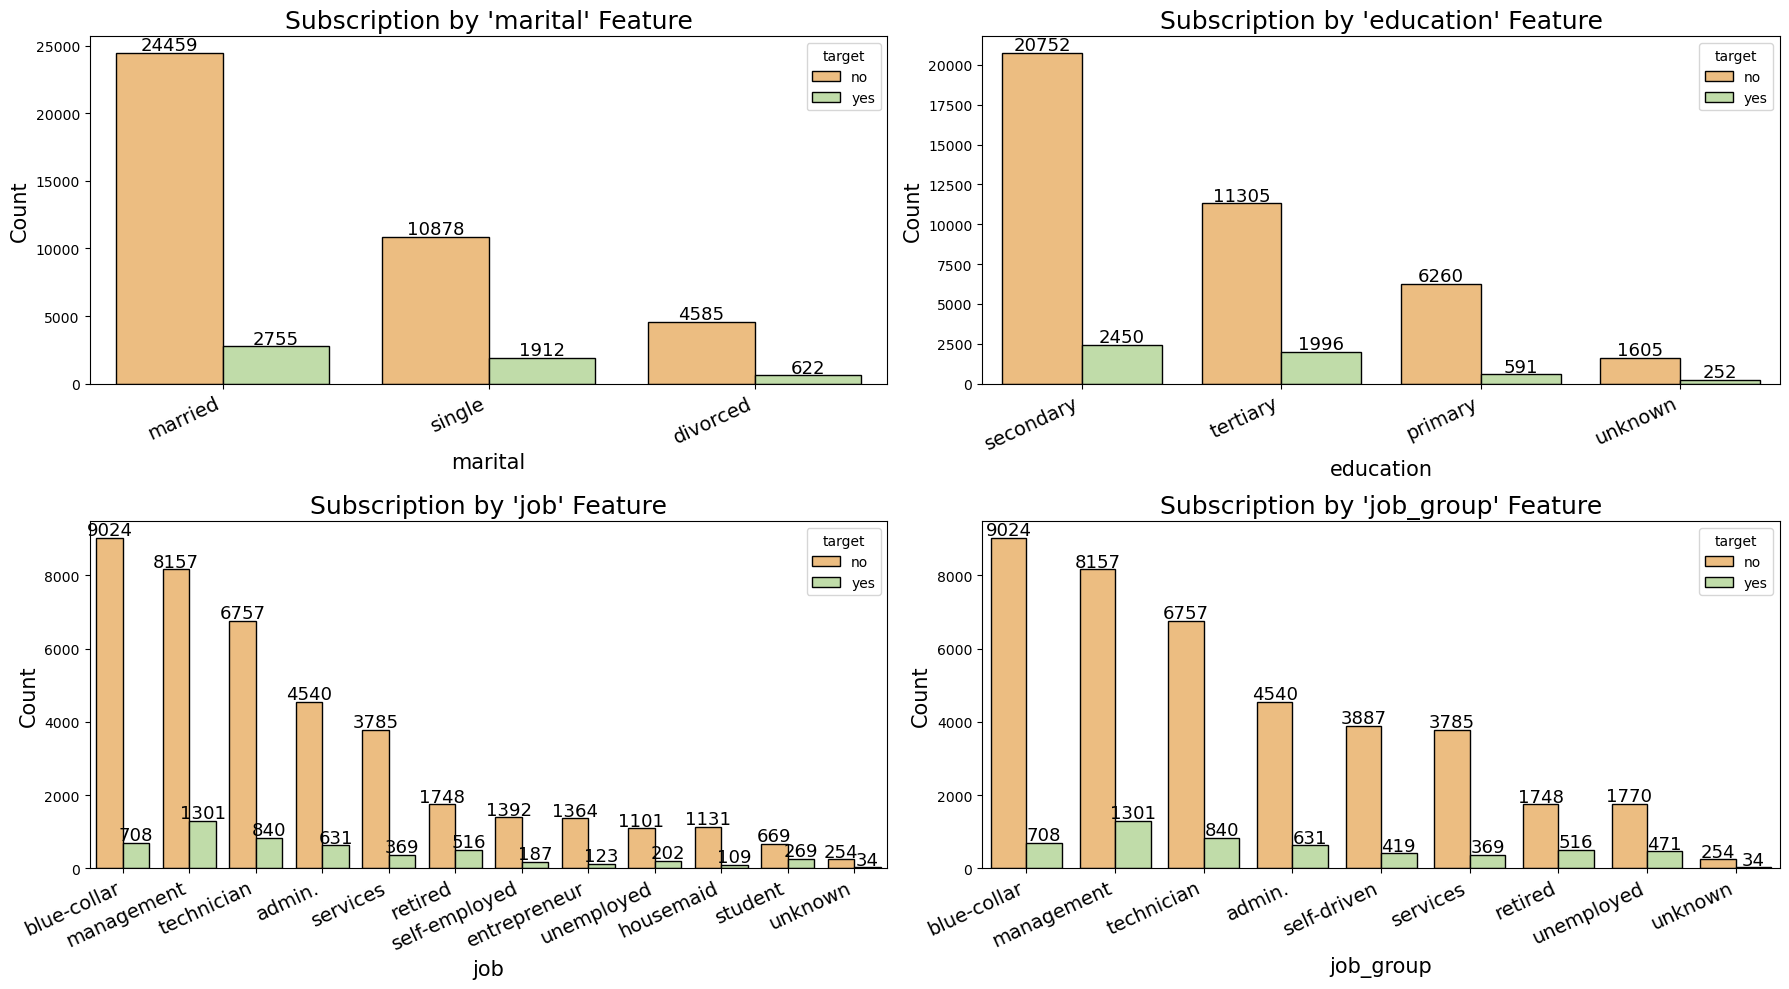

In [49]:
count_plot(data = eda_df,
           features = multi_category1,
           target_col = 'target',
           size_x = 18,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18, padding = -1)

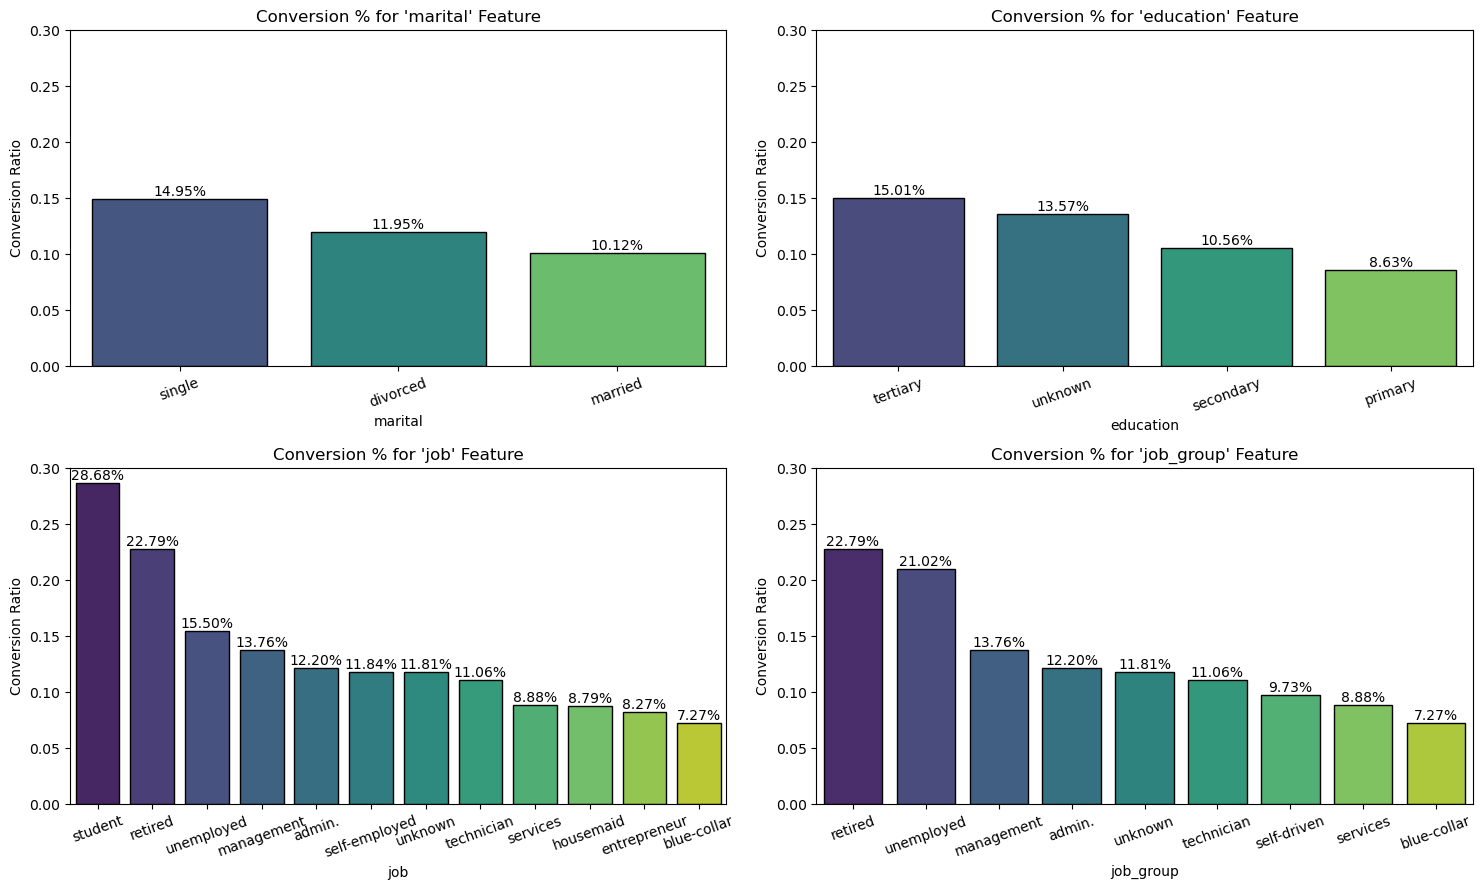

In [50]:
conversion_rate(data = eda_df,
           features = multi_category1,
           target_col = 'target_encoded',
           y_lim_max = 0.30,
           size_x = 15,
           size_y = 9,
           rot = 20)

#### **`Observations - Subscription Rate`**
**`Marital Status`**
- Conversion rate for **single** individuals is the highest with **15%** subscriptions followed by **divorced** with conversion rate of around **12%**.
- Married customers form the largest group but show the least likely conversions **(10.12%)**.
- This trend demands that banks must offer **customized** term-deposit options to improve subscriptions across marital status group.

**`Education Level`**
- In general, the chances of subscriptions increases with increasing level of education.

**`Job & Job-Group`**
- Though **retired** customers are very less in number, their conversion rate is the highest **(22.79%)**, followed by **unemployed** customers **(mostly students)** with a conversion rate around **20%**.
- **Surprisingly**, conversion rate for customers with a **blue-collar** job is the **lowest (7.27%)**.

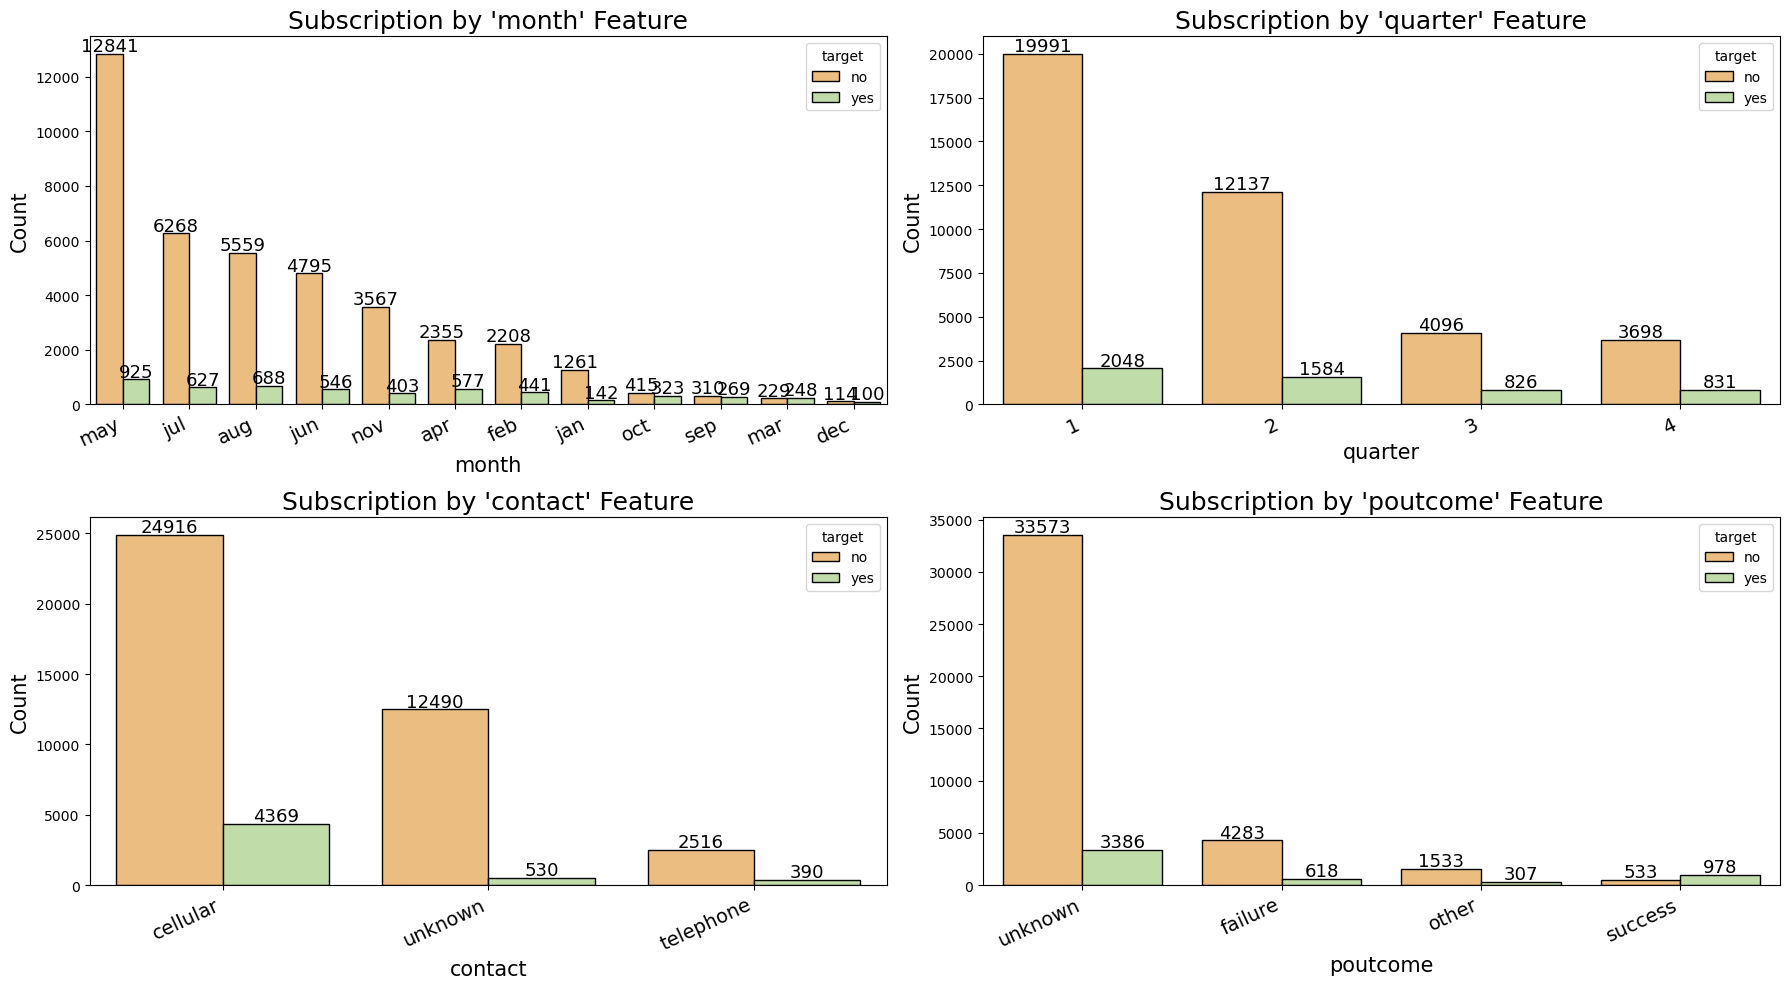

In [51]:
count_plot(data = eda_df,
           features = multi_category2,
           target_col = 'target',
           size_x = 18,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 18, padding = -1)

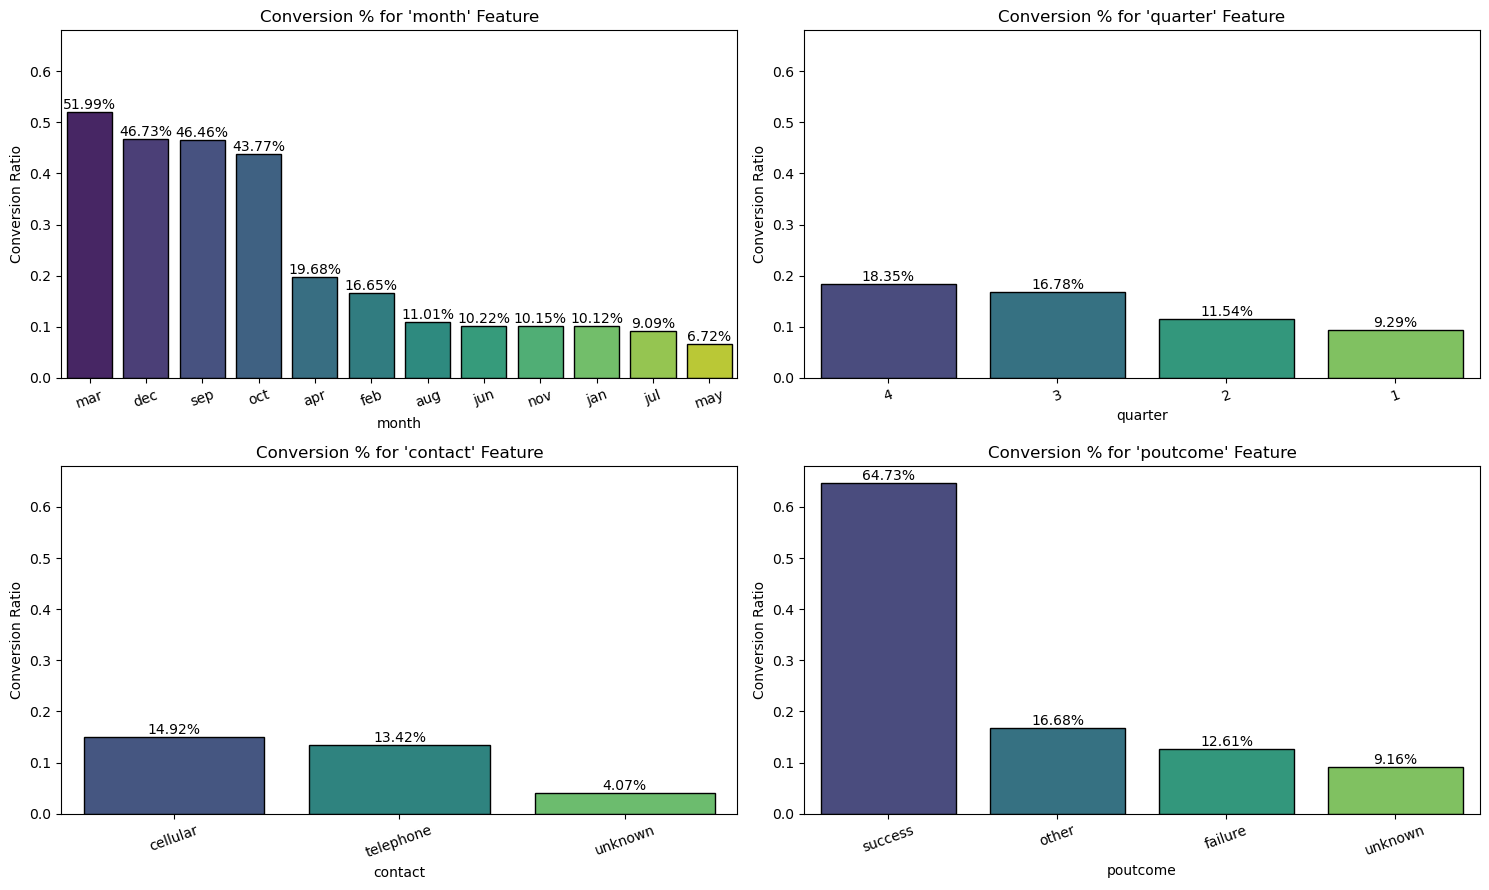

In [52]:
conversion_rate(data = eda_df,
           features = multi_category2,
           target_col = 'target_encoded',
           y_lim_max = 0.68,
           size_x = 15,
           size_y = 9,
           rot = 20)

#### **`Observations - Subscription Rate`**
**`Month & Quarter`**
- Months of **September, October, December, January & March** formed the smallest portion in terms of last contacted count. However, it is seen that customers are **more likely** to subscribe when contacted in these months.
- Even quarter-wise trend suggests - The count of customers subscribing to term deposits goes on decreasing every quarter with highest being in the 1st quarter.
- However, it is to note that higher conversions are most likely to happen in the **4th Financial Quarter** and decrease as we go back to 1st quarter.
- More campaign activities & contacts during the **second half of the year** can yield **improvement** in subscriptions.

**`Contact Mode`**
- Customers contacted over **cell/mobile** have **more** conversion rate **(14.92%)**.
- Though only **2906** customers were contacted via **telephone**, subscription rate is **13.42%** i.e. **390** have responded positively and outcome was a success.
- This demands a need to engage customers over telephone as the potential is comparable to those conacted via cellular mode.

**`Previous Outcome`**
- Among the group where previous outcome was a **success**, **978** customers have **subscribed** surpassing the **533** customers who **haven't subscribed**, making subscription rate about **75%**.
- This shows, **previous successfull** engagement **increases** likelihood for upcoming engagements. Banks may offer **loyalty** related offers for such segment of customers to boost their engagement.
- Of the **1840** customers whose previous outcome was not perfectly noted, **307** have subscribed, accounting to **16.68%** subscription rate.
- The subscription rate of **12.61%** among the group who declined during previous campaign suggests their positive shift. So banks may use it as an opportunity to maximize conversions within this segement of customers.
- Only **3386 (out of 36959)** customers, whose previous outcome was unknown, subscribed.

## **`5.4. EDA - Numerical Features`**

In [53]:
numerical_cols.remove('target_encoded')

### **`5.4.1. Basic Descriptive Stats`**

In [54]:
eda_df[numerical_cols].describe().T

count         mean          std     min    25%    50%     75%  \
age       45211.0    40.936210    10.618762    18.0   33.0   39.0    48.0   
balance   45211.0  1362.272058  3044.765829 -8019.0   72.0  448.0  1428.0   
day       45211.0    15.806419     8.322476     1.0    8.0   16.0    21.0   
duration  45211.0   258.163080   257.527812     0.0  103.0  180.0   319.0   
campaign  45211.0     2.763841     3.098021     1.0    1.0    2.0     3.0   
pdays     45211.0    40.197828   100.128746    -1.0   -1.0   -1.0    -1.0   
previous  45211.0     0.580323     2.303441     0.0    0.0    0.0     0.0   

               max  
age           95.0  
balance   102127.0  
day           31.0  
duration    4918.0  
campaign      63.0  
pdays        871.0  
previous     275.0

In [55]:
print('Skewness:\n')
print(eda_df[numerical_cols].skew())

Skewness:

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64


### **`5.4.2. Univariate Analysis`**

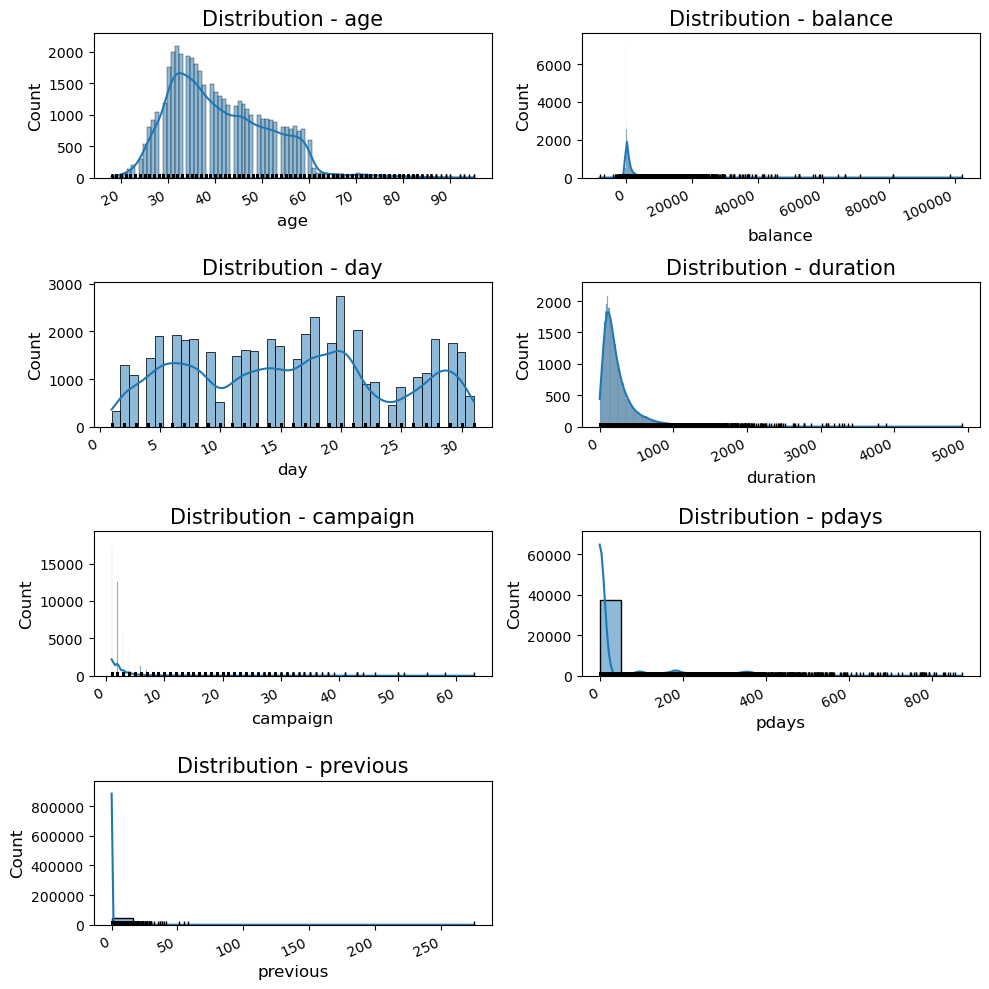

In [56]:
hist_plot(data = eda_df,
          features = numerical_cols,
          size_x = 10,
          size_y = 10)

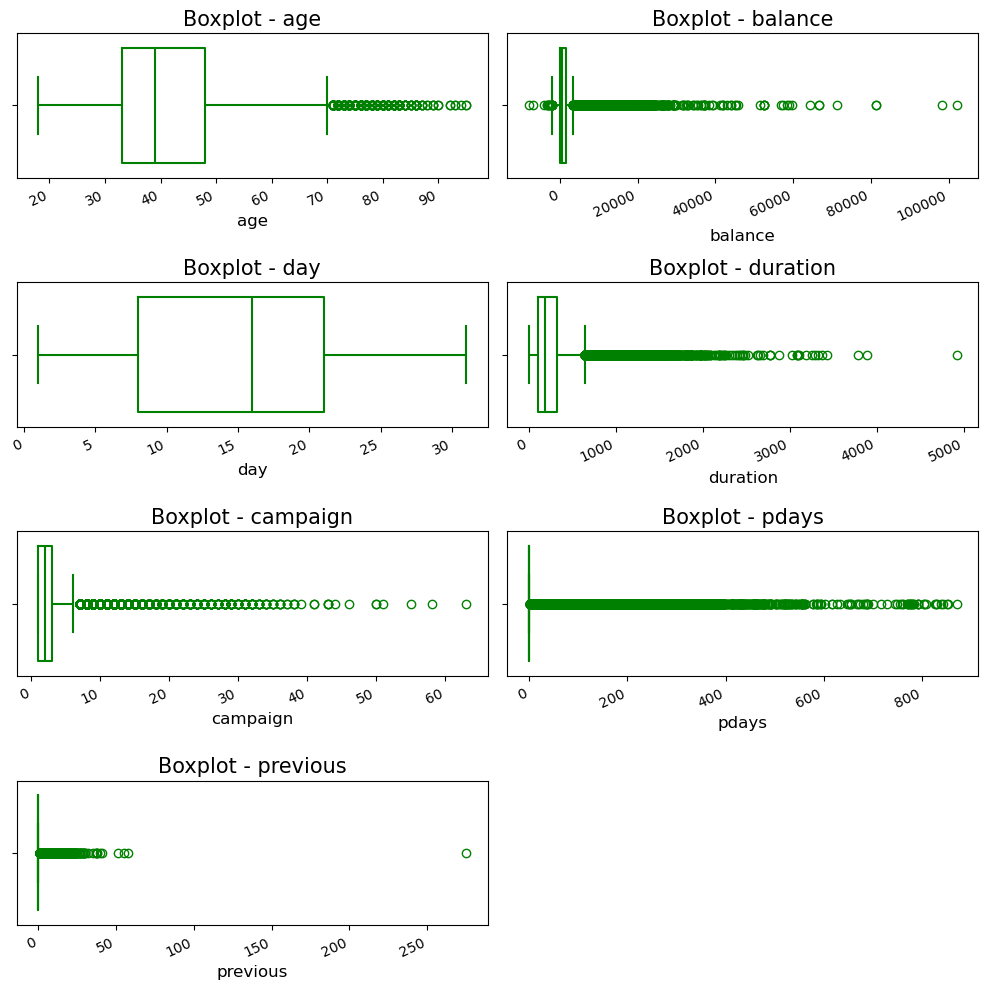

In [57]:
box_plot(data = eda_df,
         features = numerical_cols,
         size_x = 10,
         size_y = 10,
         color = 'green')

### **`5.4.3. Bivariate Analysis`**

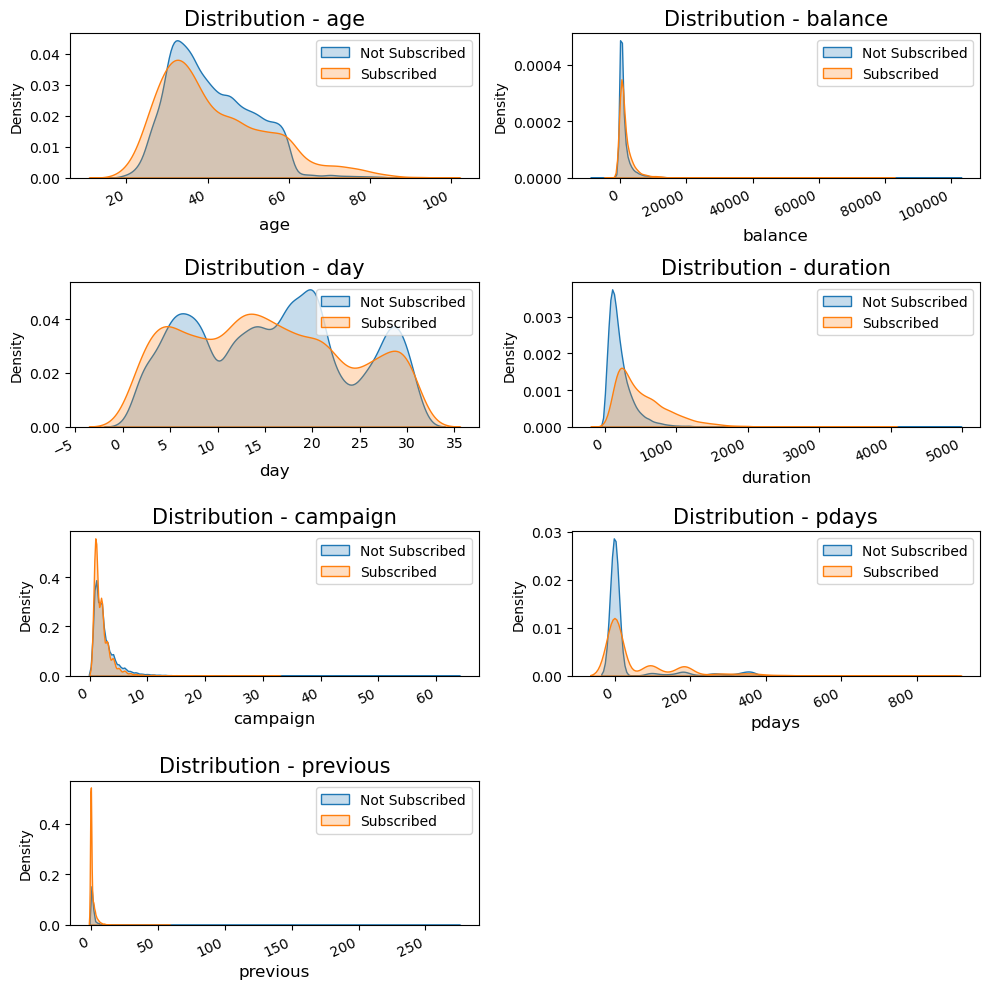

In [58]:
hist_plot(data = eda_df,
          features = numerical_cols,
          size_x = 10,
          size_y = 10,
          hue = 'target_encoded')

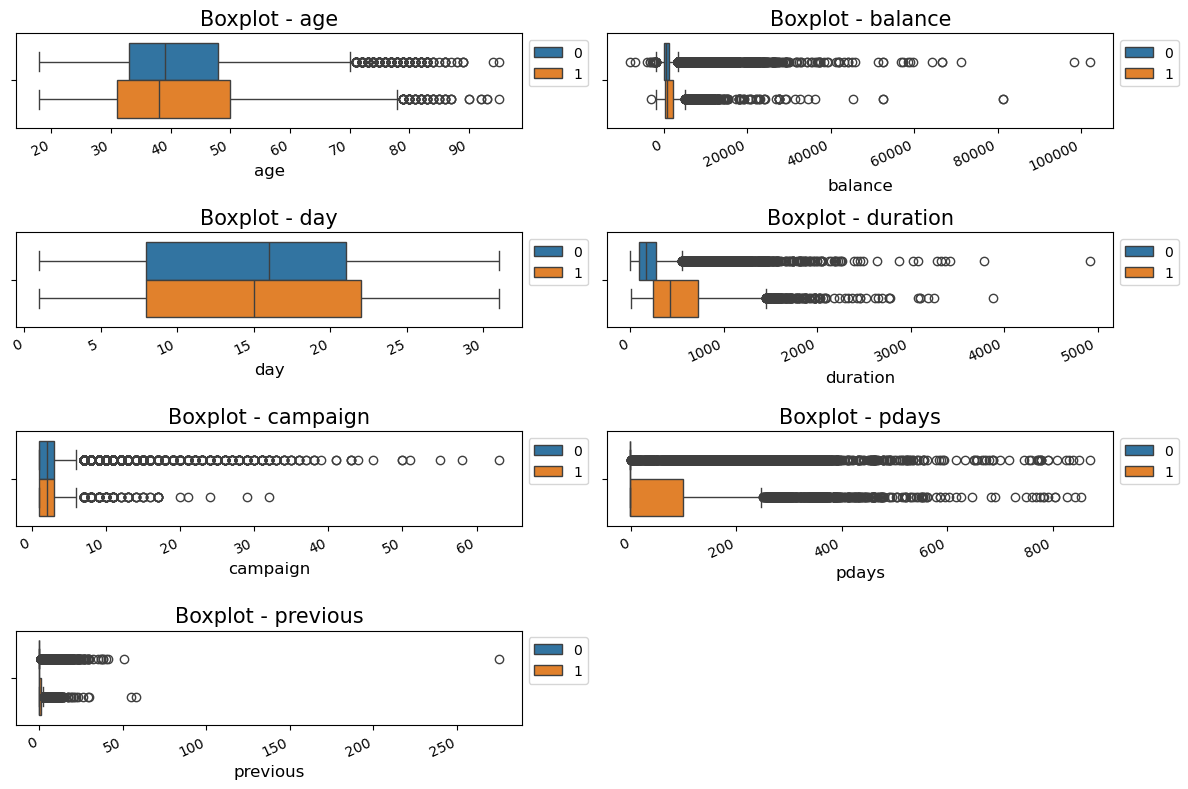

In [59]:
box_plot(data = eda_df,
          features = numerical_cols,
          size_x = 12,
          size_y = 8,
          hue = 'target_encoded',
          fill = True)

#### **`5.4. Observations`**

**`Age`**
- **age** is a numeric feature which indicates the **age of customers**.
- With a **minimum age of 18** and **maximum age of 95**, **half** of the customers are below the age of **39**.
- **75%** of the customers are aged **below 48**. From the boxplot it is evident that customers with age more than **70** can be considered as **outliers**.
- With mean slightly greater than median and skewness magnitude of **0.68**, we can infer that 'age' column is **Moderately Right-Skewed**.
- The conversions are comparitivly more for young and elder customers.

**`Balance`**
- **balance** feature indicating **average yearly balance** for each customer has a spread with values ranging from a **minimum - 8019 Euros** to **maximum 102127 Euros**.
- **50%** of the customers have average yearly balance of **upto 448 Euros**.
- With **3/4th** of the customers maintaining average yearly balance of **upto 1428 Euros**, it is certain than there are many **outliers** which needs to be handled.
- The statistics show that mean balance is 1362 Euros which is very far from the median of 448 Euros. Also the **skewness** magnitude is **8.36**. So we can conclude that 'balance' feature is **Heavily Right-Skewed**.

**`Day`**
- **day** feature specifies the **date** on which the customers were last contacted.
- 'day' is a discrete numerical feature.
- We will explore 'day' feature in the subsequent section as there is no specific pattern seen in the initial analysis.

**`Duration`**
- **duration** is a continuous numerical feature that indicates the **last contact duration** for a customer.
- The **unit** for duration of calls is **seconds**.
- **Half** of the contacted customers have a call duration upto **180 seconds (3 min)**, whereas there are **75%** of the customers with call duration of upto **319 seconds (5.31 min)**.
- There are 3 customers with call duration as 0 seconds. So it is ambiguous to tell if the customer was contacted or not. We need to expore it further.
- There are many **outliers** which needs to be handled.
- Average call duration for customers who **subscribed** to the term deposits is around **425-538 seconds**; Whereas for customers who **didn't subscribe**, average call duration is **164-221 seconds**. i.e. More the engaging time, more is the possibility of conversion.

**`Campaign`**
- **campaign** is a discrete numerical feature that shows number of contacts performed during this campaign and for a particular customer.
- 75% of the customers are contacted upto **3 times** with minimum being 1 time and maximum being 63 times.
- There are many **outliers** which needs to be handled.
- Repeated contacts of more than 30 has showed 0% conversions highlighting the need to optimize contacts.

**`Pdays`**
- Right-skewed, indicating many individuals were not previously contacted (value of -1).
- Those contacted have widely varying intervals since last contact.

**`Previous`**
- Drastically right-skewed, showing that most individuals have not been previously contacted or contacted very few times.
- Some have been contacted multiple times, suggesting responsiveness or significance.

We will study the impact of this numerical features on target in the later section by binning this features into discrete categories.

### **`5.4.4. Binning/Discretization`**

In [60]:
def binning(data):
    return (
        data
        .assign(
            week = lambda df_: pd.cut(df_['day'], bins = [0,7,14,21,31], labels = [1,2,3,4]).astype('category'),
            age_group = lambda df_: pd.cut(df_['age'], bins = [17,29,35,40,45,50,100],
                                           labels = ['Young Adults', 'Early Professionals', 'Mid-Career', 
                                                     'Established Professionals', 'Pre-Retirement',
                                                     'Seniors']).astype('category'),       
            balance_group = lambda df_: pd.cut(df_['balance'], bins = [float('-inf'),208,1293,2378,float('inf')],
                                              labels = ['low', 'medium-low', 'medium-high', 'high']).astype('category') ,
            duration_group = lambda df_: pd.cut(df_['duration'], bins = [-1,120,240,360,480,float('inf')],
                                               labels = ['Very Short', 'Short', 'Medium', 'Long', 'Very Long']).astype('category')
        )
    )

In [61]:
eda_df = binning(eda_df)
eda_df.head(2)

age         job  marital  education default  balance housing loan  contact  \
0   58  management  married   tertiary      no     2143     yes   no  unknown   
1   44  technician   single  secondary      no       29     yes   no  unknown   

   day month  duration  campaign  pdays  previous poutcome target quarter  \
0    5   may       261         1     -1         0  unknown     no       1   
1    5   may       151         1     -1         0  unknown     no       1   

    job_group  target_encoded week                  age_group balance_group  \
0  management               0    1                    Seniors   medium-high   
1  technician               0    1  Established Professionals           low   

  duration_group  
0         Medium  
1          Short

In [62]:
bin_features = ['week','age_group','balance_group','duration_group']

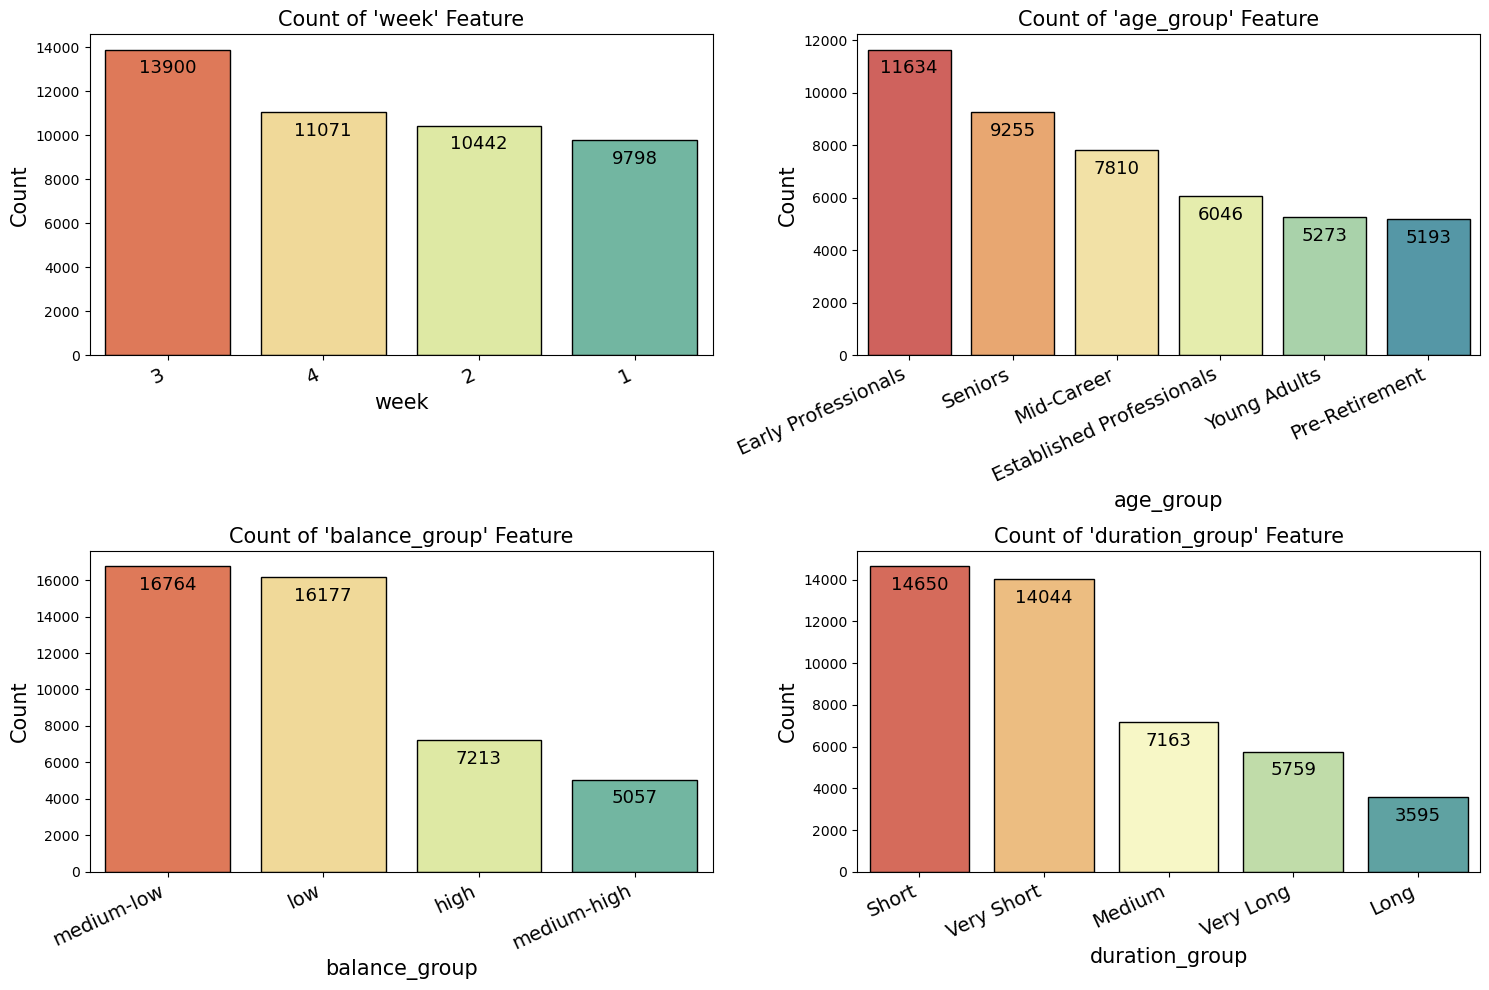

In [63]:
count_plot(data = eda_df,
           features = bin_features,
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 15)

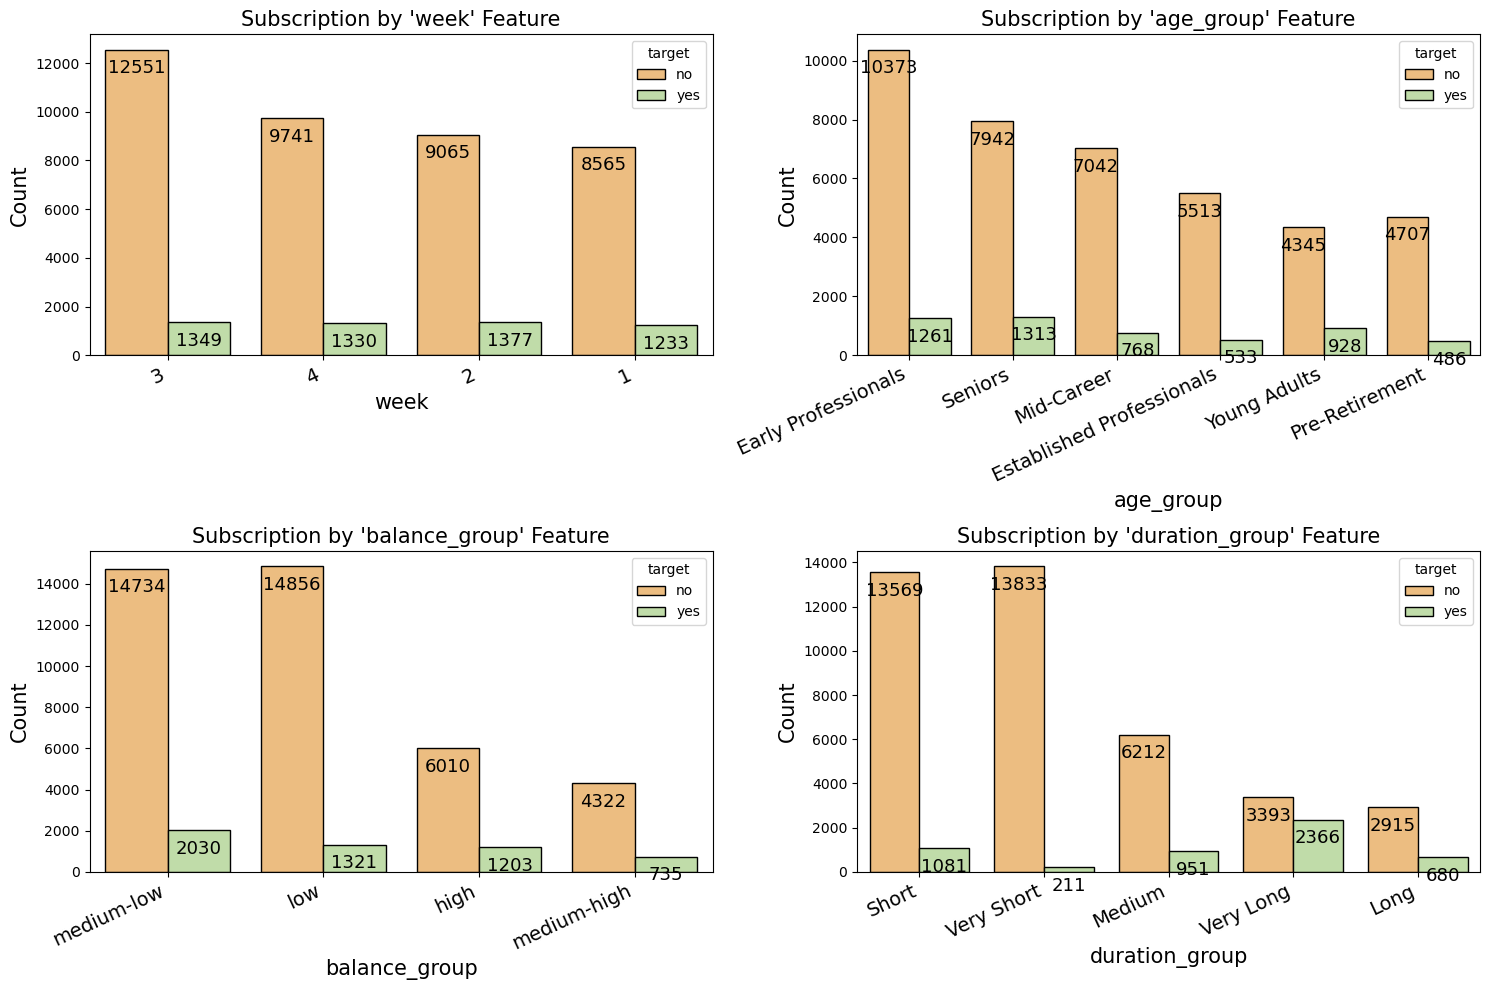

In [64]:
count_plot(data = eda_df,
           features = bin_features,
           target_col = 'target',
           size_x = 15,
           size_y = 10,
           xlabel_size = 15,
           ylabel_size = 15,
           title_size = 15)

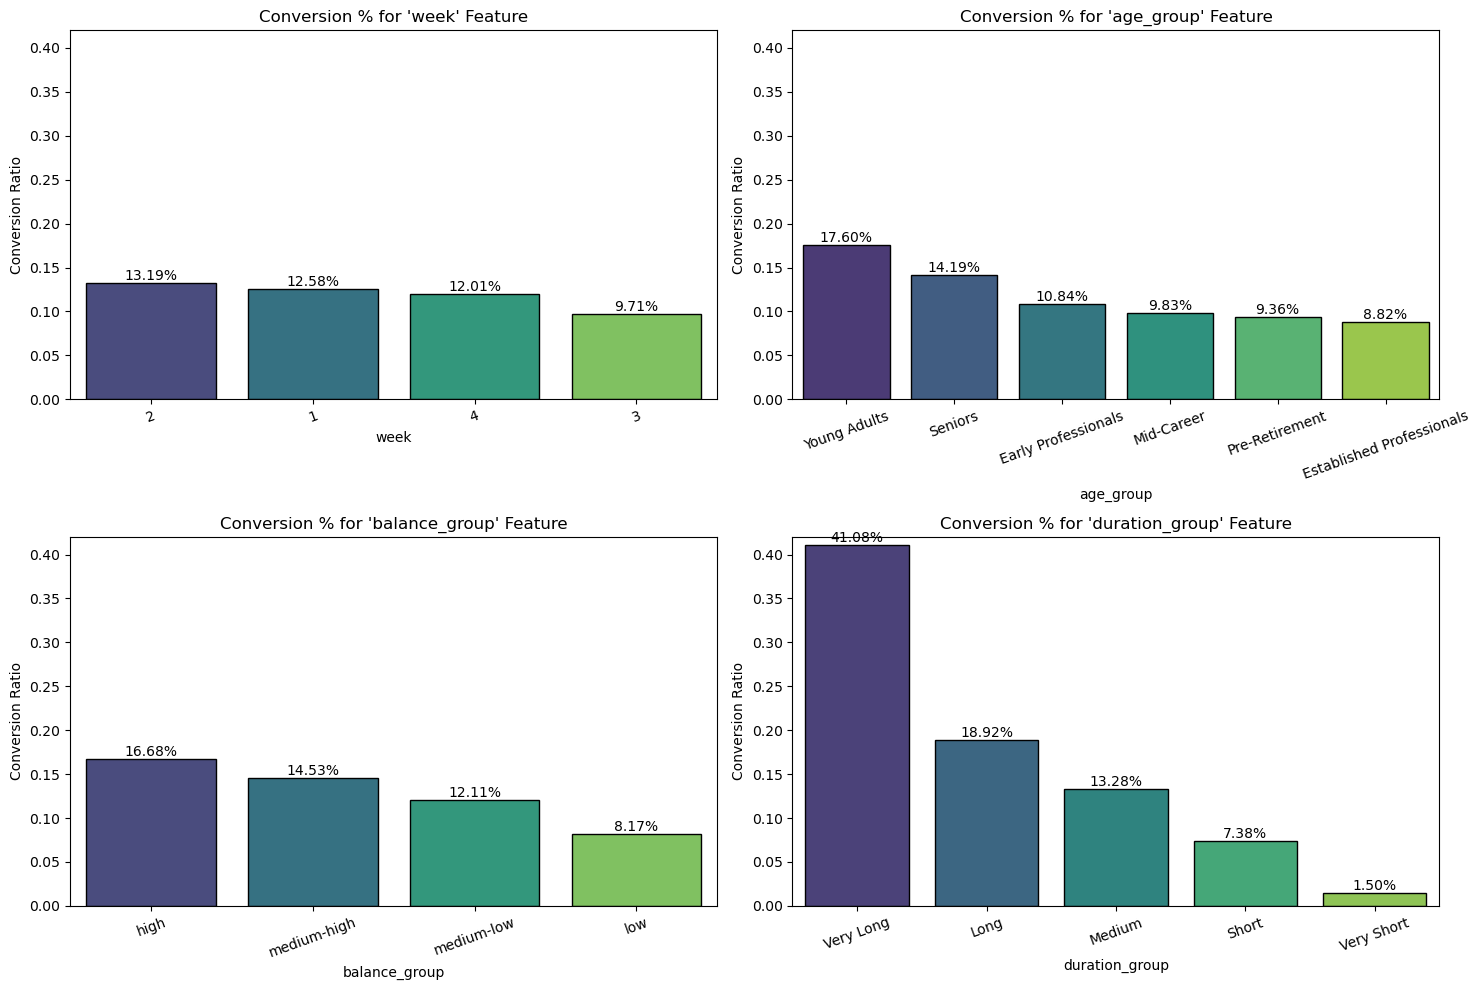

In [65]:
conversion_rate(data = eda_df,
                features = bin_features,
                target_col = 'target_encoded',
                y_lim_max = 0.42,
                size_x = 15,
                size_y = 10,
                rot = 20)

#### **`Observations`**

**`Week`**
- **Most** calls are made in the **3rd week** of the month, followed by **4th week**.
- However conversions are **less likely** to happen in the **3rd week**.
- Conversion rate are **more likely** to happen in the **1st** and **2nd week**.

**`Age-Group`**
- **Majority** of the customers fall in the age group of **Early Professionals** followed by **Seniors**, **Mid-Career** and then **Established Professionals**.
- Whereas **Pre-Retirement** forms the lowest count followed by **Young Adults**.
- However, the chances of conversions are **highest** for **Young Adults (17.6%)** and **Seniors (14.19%)** as opposed to **Pre-Retirement (9.36%)** and **Established Professionals (8.82%)**.
- Bank must therefore cater and target younger and senior customers to improve conversions even further.

**`Balance-Group`**
- **Majority** of customers fall in the **medium-low** and **low** balance category whereas customers that belong to **high** and **medium-high** are **16%** and **11%** respectively.
- It is evident that customers with **high** balance category are more likely to subscribe to the term deposits as opposed to customers with **low** balance category **(16.68% vs 8.16%)**.

**`Duration-Group`**
- **Short duration** calls are the **highest** in numbers followed by very short duration calls. **Long** duration calls are **very infrequent**.
- It is very clear that the chances of conversions are **directly proportional** to the duration of call. i.e. for **very-long** call durations the conversion rate is **41%** as opposed to **very-short** call durations **(1.5%)**. 

### **`5.4.5. Multivariate Analysis`**

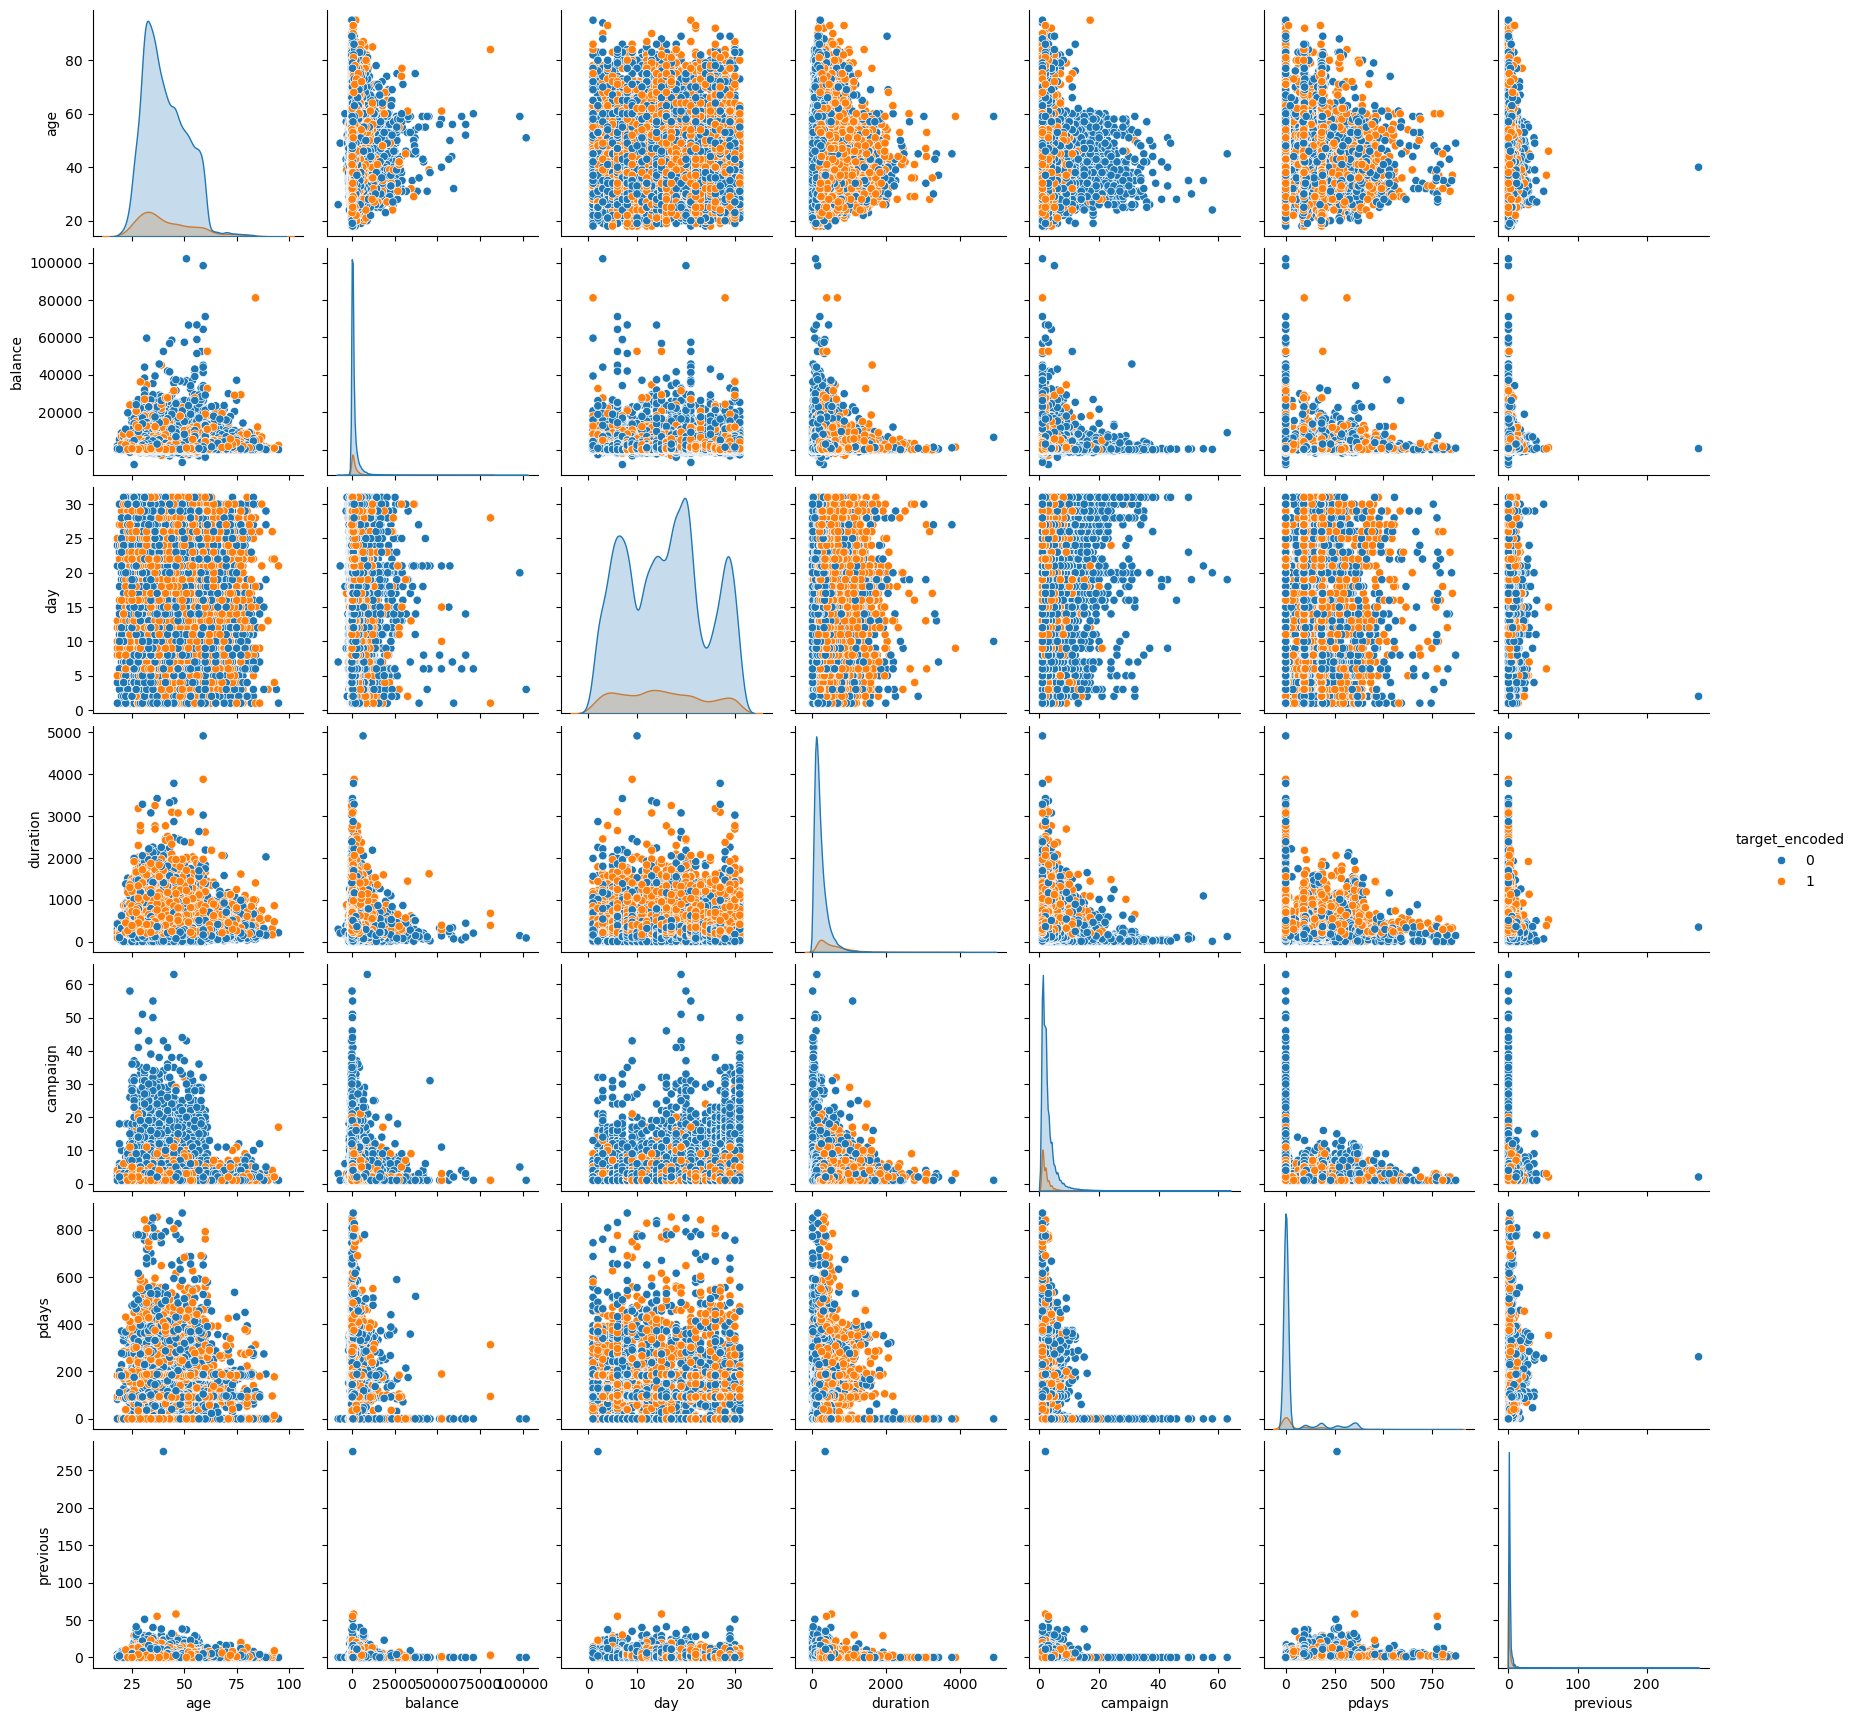

In [66]:
sns.pairplot(eda_df, hue = 'target_encoded')
plt.show()

### **`5.4.6. Outlier Analysis`**

In [67]:
def outliers(df, feature):
    Col, Q1, Q3, IQR = [], [], [], []
    LL, UL, Count, Percent = [], [], [], []
    Min, Max = [], []
    for col in feature:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
    
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
    
        count = df[(df[col] > upper_limit) | (df[col] < lower_limit)].shape[0]
        percent = round((count/df.shape[0])*100, 2)

        Col.append(col)
        Q1.append(q1)
        Q3.append(q3)
        IQR.append(iqr)
        LL.append(lower_limit)
        UL.append(upper_limit)
        Count.append(count)
        Percent.append(percent)
        Min.append(df[col].min())
        Max.append(df[col].max())

    df = pd.DataFrame(data = {'Feature': Col, 'Q1': Q1, 'Q3': Q3, 'IQR': IQR, 'Minimum': Min,
                              'Maximum': Max,'Lower Limit': LL, 'Upper Limit': UL,
                              'Count of Outliers': Count, 'Outlier %': Percent})
    df.set_index(['Feature'], inplace = True)
    return df

In [68]:
outliers_df = outliers(eda_df, numerical_cols)
outliers_df

Q1      Q3     IQR  Minimum  Maximum  Lower Limit  Upper Limit  \
Feature                                                                       
age        33.0    48.0    15.0       18       95         10.5         70.5   
balance    72.0  1428.0  1356.0    -8019   102127      -1962.0       3462.0   
day         8.0    21.0    13.0        1       31        -11.5         40.5   
duration  103.0   319.0   216.0        0     4918       -221.0        643.0   
campaign    1.0     3.0     2.0        1       63         -2.0          6.0   
pdays      -1.0    -1.0     0.0       -1      871         -1.0         -1.0   
previous    0.0     0.0     0.0        0      275          0.0          0.0   

          Count of Outliers  Outlier %  
Feature                                 
age                     487       1.08  
balance                4729      10.46  
day                       0       0.00  
duration               3235       7.16  
campaign               3064       6.78  
pdays                  8257      18.26  
previous               8257      18.26

#### **`Observations`**
**`Age`**
- Only **`1.08%`** of customers appear to be in extreme age category, however these ages are realistic.
- **Binary flag** for outliers can be introduced as well as age **IQR winsorization** to cap extreme values can be done.

**`Balance`**
- This feature is heavily right-skewed.
- High balance has shown high subscriptions, making these extreme values highly predictive in nature.
- **Log Transformation** can be applied to reduce the effect of skewness and capture raw nature.

**`Day`**
- There are **no** outliers. No treatement required.

**`Duration`**
- It is observed that duration length increases the likelihood of subscriptions.
- To keep the real impact of call duration intact, **7.16%** skewness and outlier effect can be minimized by applying **Log Transformation**

**`Campaign`**
- **Capping** and **flagging** extreme values can be done to handle **6.78%** outliers.

**`Pdays & Previous`**
- **18.26%** outliers actually represent that the customers were previously not contacted.
- To handle the effect, a binary flag - **contacted_previously** can be introduced.
- Original features **pdays** & **previous** can be **dropped**.

In [69]:
df.to_csv("data_basic_cleaning.csv", index = False)
data.to_csv("data.csv", index = False)
eda_df.to_csv("data_eda.csv", index = False)